# Predict Future Sales Competition

*This notebook serves as final project for the "How to win a data science competition" Coursera course*.
This challenge is also posted on kaggle.com.
(https://www.kaggle.com/c/competitive-data-science-predict-future-sales)

In this competition I worked with a challenging time-series dataset consisting of daily sales data, kindly provided by the largest Russian software firms - 1C Company.
The goal is to predict total sales for every product and store in the next month. The list of shops and products slightly changes every month. Creating a robust model that can handle such situations is part of the challenge.


### File descriptions

sales_train.csv - the training set. Daily historical data from January 2013 to October 2015.  
test.csv - the test set. You need to forecast the sales for these shops and products for November 2015.  
sample_submission.csv - a sample submission file in the correct format.  
items.csv - supplemental information about the items/products.  
item_categories.csv  - supplemental information about the items categories.  
shops.csv- supplemental information about the shops.   

Data fields  

ID - an Id that represents a (Shop, Item) tuple within the test set
shop_id - unique identifier of a shop  
item_id - unique identifier of a product    
item_category_id - unique identifier of item category  
item_cnt_day - number of products sold. You are predicting a monthly amount of this measure  
item_price - current price of an item  
date - date in format dd/mm/yyyy  
date_block_num - a consecutive month number, used for convenience. January 2013 is 0, February 2013 is 1,..., October 2015 is 33  
item_name - name of item  
shop_name - name of shop  
item_category_name - name of item category  


## Table of Contents

I. [Exploratory Data Analysis](#Exploratory-Data-Analysis)<br>
II. [Feature Engineering](#Feature)<br>
III. [Train Test Split and Model Selection](#Selection)<br>
IV. [Model 1 - XGBoost](#XGboost)<br>
IV. [Model 2 - NLP/SGD](#NLP)<br>
V. [Ensembling](#Ensembling)<br>
VI. [Conclusions](#conclusions)


In [285]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import gc
import time
from itertools import product
from xgboost import plot_importance
import xgboost as xgb
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import mean_squared_error
from collections import defaultdict
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, TfidfVectorizer
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from sklearn.ensemble import RandomForestRegressor
import re
from nltk.stem import SnowballStemmer
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import SGDRegressor
import joblib

#nltk.download('punkt')
#nltk.download('stopwords')
#nltk.download('wordnet')

import helper


from xgboost import XGBRegressor

%matplotlib inline 
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [2]:
DATA_FOLDER = ''

transactions    = pd.read_csv(os.path.join(DATA_FOLDER, 'sales_train.csv'))
items           = pd.read_csv(os.path.join(DATA_FOLDER, 'items.csv'))
item_categories = pd.read_csv(os.path.join(DATA_FOLDER, 'item_categories.csv'))
shops           = pd.read_csv(os.path.join(DATA_FOLDER, 'shops.csv'))
test            = pd.read_csv(os.path.join(DATA_FOLDER, 'test.csv'))
#submission      = pd.read_csv(os.path.join(DATA_FOLDER, 'sample_submission.csv'))

In [3]:
transactions.shape

(2935849, 6)

In [4]:
transactions = helper.downgrade_dtypes(transactions)
test = helper.downgrade_dtypes(test)
items = helper.downgrade_dtypes(items)
item_categories = helper.downgrade_dtypes(item_categories)
shops = helper.downgrade_dtypes(shops)

### <a class="anchor" id="Exploratory-Data-Analysis">Part I : Exploratory Data Analysis</a>


### `1.`  Descriptive statistics

In [5]:
transactions.describe()

,date_block_num,shop_id,item_id,item_price,item_cnt_day
count,2.935849e+06,2.935849e+06,2.935849e+06,2.935849e+06,2.935849e+06
mean,1.456991e+01,3.300173e+01,1.019723e+04,8.906234e+02,1.242641e+00
std,9.422988e+00,1.622697e+01,6.324297e+03,1.726440e+03,2.612213e+00
min,0.000000e+00,0.000000e+00,0.000000e+00,-1.000000e+00,-2.200000e+01
25%,7.000000e+00,2.200000e+01,4.476000e+03,2.490000e+02,1.000000e+00
50%,1.400000e+01,3.100000e+01,9.343000e+03,3.990000e+02,1.000000e+00
75%,2.300000e+01,4.700000e+01,1.568400e+04,9.990000e+02,1.000000e+00
max,3.300000e+01,5.900000e+01,2.216900e+04,3.079800e+05,2.169000e+03


In [6]:
items.describe()

,item_id,item_category_id
count,22170.00000,22170.000000
mean,11084.50000,46.290753
std,6400.07207,15.941486
min,0.00000,0.000000
25%,5542.25000,37.000000
50%,11084.50000,40.000000
75%,16626.75000,58.000000
max,22169.00000,83.000000


In [7]:
item_categories.describe()

,item_category_id
count,84.000000
mean,41.500000
std,24.392622
min,0.000000
25%,20.750000
50%,41.500000
75%,62.250000
max,83.000000


In [8]:
shops.describe()

,shop_id
count,60.000000
mean,29.500000
std,17.464249
min,0.000000
25%,14.750000
50%,29.500000
75%,44.250000
max,59.000000


### `2.`  Explore duplicated data

In [9]:
print(transactions.shape)
print(transactions[transactions.duplicated()])
#print(transactions.query('item_id==20130 & shop_id==54'))
#print(transactions.query('item_id==3423 & shop_id==50'))
#print(transactions.query('item_id==3423 & shop_id==21'))
#print(transactions.query('item_id==3423 & shop_id==25'))
#print(transactions.query('item_id==21619 & shop_id==42'))
print(items[items["item_id"] == 3423])
print(items[items["item_id"] == 21619])
print(items[items["item_id"] == 20130])
print(transactions.shape)
transactions[transactions.duplicated()]

(2935849, 6)
               date  date_block_num  shop_id  item_id  item_price  \
76962    05.01.2013               0       54    20130       149.0   
1435367  23.02.2014              13       50     3423       999.0   
1496766  23.03.2014              14       21     3423       999.0   
1671873  01.05.2014              16       50     3423       999.0   
1866340  12.07.2014              18       25     3423       999.0   
2198566  31.12.2014              23       42    21619       499.0   

         item_cnt_day  
76962             1.0  
1435367           1.0  
1496766           1.0  
1671873           1.0  
1866340           1.0  
2198566           1.0  
                                            item_name  item_id  \
3423  Far Cry 3 (Classics) [Xbox 360, русская версия]     3423   

      item_category_id  
3423                23  
                item_name  item_id  item_category_id
21619  ЧЕЛОВЕК ДОЖДЯ (BD)    21619                37
                     item_name  item_id  item_

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
76962,05.01.2013,0,54,20130,149.0,1.0
1435367,23.02.2014,13,50,3423,999.0,1.0
1496766,23.03.2014,14,21,3423,999.0,1.0
1671873,01.05.2014,16,50,3423,999.0,1.0
1866340,12.07.2014,18,25,3423,999.0,1.0
2198566,31.12.2014,23,42,21619,499.0,1.0


There are 6 duplicated items. Checking these 6 items revealed that these are just the popular items that were bought twice in the same day. These items will be kept these items.

In [10]:
print(items.shape)
print("Number of duplicated item rows {}".format(items.duplicated().sum()))
items.head()

(22170, 3)
Number of duplicated item rows 0


,item_name,item_id,item_category_id
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40
1,!ABBYY FineReader 12 Professional Edition Full...,1,76
2,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40
3,***ГОЛУБАЯ ВОЛНА (Univ) D,3,40
4,***КОРОБКА (СТЕКЛО) D,4,40


In [11]:
print(item_categories.shape)
print("Number of duplicated categories rows {}".format(item_categories.duplicated().sum()))
item_categories.head()

(84, 2)
Number of duplicated categories rows 0


,item_category_name,item_category_id
0,PC - Гарнитуры/Наушники,0
1,Аксессуары - PS2,1
2,Аксессуары - PS3,2
3,Аксессуары - PS4,3
4,Аксессуары - PSP,4


In [12]:
print(shops.shape)
print("Number of duplicated shops {}".format(shops.duplicated().sum()))
shops.head()

(60, 2)
Number of duplicated shops 0


,shop_name,shop_id
0,"!Якутск Орджоникидзе, 56 фран",0
1,"!Якутск ТЦ ""Центральный"" фран",1
2,"Адыгея ТЦ ""Мега""",2
3,"Балашиха ТРК ""Октябрь-Киномир""",3
4,"Волжский ТЦ ""Волга Молл""",4


In [13]:
print(test.shape)
print(test.tail())
print("Number of unique shops in test set {}.".format(test["shop_id"].nunique()))
print("Number of unique items in test set {}.".format(test["item_id"].nunique()))

(214200, 3)
            ID  shop_id  item_id
214195  214195       45    18454
214196  214196       45    16188
214197  214197       45    15757
214198  214198       45    19648
214199  214199       45      969
Number of unique shops in test set 42.
Number of unique items in test set 5100.


### `3.`  General information
There are 22170 items, and 60 shops. The total possible number of combinations 22170*60 = 1330200. The test set consists of 42 unique shops and 5100 items. The total number of instances is 214200 wich is exactly the number of cobinations between 42 shops and 5100 items.

#### generate sample submission with some constant

In [14]:
y_test = np.full((test.index.shape[0]), 1.0)
helper.create_submission_csv('submission.csv', test, y_test)

The submission with "ones" resulted in 1.41241 score on the kaggle leaderboard.

### `4.` Investigate shops and items

#### Explore total number of sold items by shop over all period of time

In [15]:
#transform date to pandas datetime format
transactions["date"] = pd.to_datetime(transactions["date"], format="%d.%m.%Y")

[]

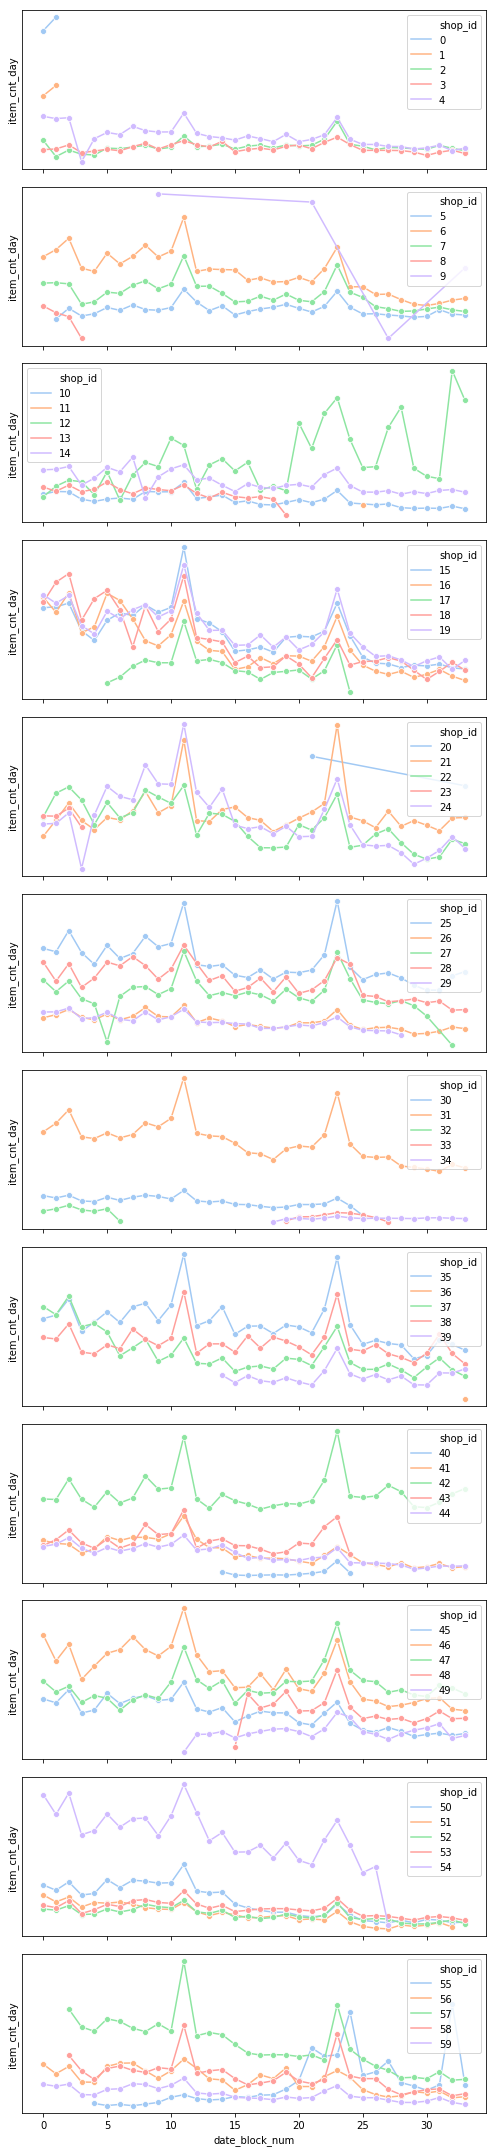

In [16]:
#plot number sold items each month per shop
temp = transactions.groupby(["date_block_num","shop_id"], as_index=False).agg({"item_cnt_day": 'sum', "item_price": 'mean'})
f, axes = plt.subplots(12, figsize=(7, 30), sharex=True)
count=0
for shop_id in range(0,60,5):
    sns.lineplot(x='date_block_num', y='item_cnt_day', hue='shop_id', palette=sns.color_palette('pastel', n_colors=5), 
                 data=temp[temp["shop_id"].isin(range(shop_id,shop_id+5))], ax=axes[count], legend='full', marker="o")
    count += 1

plt.setp(axes, yticks=[])
plt.tight_layout()

The seasonality is clearly present in many shops. There are usually sharp increases in the number of sold items in blocks 11 and 23, Dec 2013 and Dec 2014 respectively. However there are shops that have about the same number of items sold during whole period of time. These shops have a negligible increase in number of sold items during the holiday period.  

In [17]:
no_season_shops = [4,10,26,29,34,30,33,34,44,59]

In [18]:
print(shops[shops["shop_id"].isin(no_season_shops)]["shop_name"])

4               Волжский ТЦ "Волга Молл"
10            Жуковский ул. Чкалова 39м?
26           Москва ТЦ "Ареал" (Беляево)
29    Москва ТЦ "Новый век" (Новокосино)
30                Москва ТЦ "Перловский"
33                     Мытищи ТРК "XL-3"
34                  Н.Новгород ТРЦ "РИО"
44                   Самара ТЦ "Мелодия"
59                Ярославль ТЦ "Альтаир"
Name: shop_name, dtype: object


#### What shops worked during short periods of time?
- Shops 0 and 1 worked only during blocks 0 and 1.
- Shop 8 worked in blocks 0-4.
- Shop 9 worked in blocks 9, 21, 27, 33 
- Shop 11 workedd only in block 25.
- Shop 13 worked up to block 19. 
- Shop 17 worked from 5-24.
- Shop 20 worked only in block 21 and 33.
- Shop 23 worked in blocks 0-4.
- Shop 32 worked in 0-6.
- Shop 33 worked in 19-27.
- Shop 36 worked in 33.
- Shop 40 worked in 14-24

#### Are these shops present in the test set?

In [19]:
short_term_shops = [0,1,8,9,11,13,17,20,23,32,33,36,40]
print(test[test["shop_id"].isin(short_term_shops)]["shop_id"].unique())
short_term_shops.remove(36)
short_term_shops

[36]


[0, 1, 8, 9, 11, 13, 17, 20, 23, 32, 33, 40]

Only shop #36 present in test set and it only worked during block 33. So, it just started its business in block 33.


In [20]:
print(shops[shops["shop_id"].isin(short_term_shops)]["shop_name"])

0                       !Якутск Орджоникидзе, 56 фран
1                       !Якутск ТЦ "Центральный" фран
8                        Воронеж ТРЦ Сити-Парк "Град"
9                                   Выездная Торговля
11                         Жуковский ул. Чкалова 39м²
13                                Казань ТЦ "Бехетле"
17                      Красноярск ТЦ "Взлетка Плаза"
20                                Москва "Распродажа"
23                   Москва ТК "Буденовский" (пав.А2)
32                         Москва ТЦ "Серебряный Дом"
33                                  Мытищи ТРК "XL-3"
40    РостовНаДону ТРК "Мегацентр Горизонт" Островной
Name: shop_name, dtype: object


In [21]:
print(shops["shop_name"])

0                       !Якутск Орджоникидзе, 56 фран
1                       !Якутск ТЦ "Центральный" фран
2                                    Адыгея ТЦ "Мега"
3                      Балашиха ТРК "Октябрь-Киномир"
4                            Волжский ТЦ "Волга Молл"
5                              Вологда ТРЦ "Мармелад"
6                          Воронеж (Плехановская, 13)
7                              Воронеж ТРЦ "Максимир"
8                        Воронеж ТРЦ Сити-Парк "Град"
9                                   Выездная Торговля
10                         Жуковский ул. Чкалова 39м?
11                         Жуковский ул. Чкалова 39м²
12                                Интернет-магазин ЧС
13                                Казань ТЦ "Бехетле"
14                            Казань ТЦ "ПаркХаус" II
15                               Калуга ТРЦ "XXI век"
16                                   Коломна ТЦ "Рио"
17                      Красноярск ТЦ "Взлетка Плаза"
18                          

Shop 10 and 11 are similar shops. That is why shop 11 is present in block 25 and shop 10 is missed in block 25.  
Shop 10 present in test set.  
Shop 0 is shop 57.    
Shop 1 is shop 58.  

#### Correct the shop ids and names

In [22]:
helper.rename_shop_ids(transactions)
helper.rename_shop_ids(temp)    

#check that shop 10 was renamed to 11
print((transactions["shop_id"]==11).sum(), (test["shop_id"]==11).sum())

0 0


#### Consider removing of the shops that are not present during in test set and worked short period of time

In [23]:
shops_to_delete = [8, 9, 13, 20, 23, 32, 33, 40]
print("Original size of shops DF: {}".format(transactions.shape))
transactions.drop(transactions[transactions.shop_id.isin(shops_to_delete)].index, axis=0, inplace=True)
temp.drop(temp[temp.shop_id.isin(shops_to_delete)].index, axis=0, inplace=True)
print("Size of DF after some shops were deleted: {}".format(transactions.shape))

Original size of shops DF: (2935849, 6)
Size of DF after some shops were deleted: (2884876, 6)


#### Check if all of the shop_id item_id test set combinations are present in train_set

In [24]:
shop_item_missing = np.setdiff1d(test[["shop_id","item_id"]], transactions[["shop_id","item_id"]])
print("There are {} shops and item combinations that are present in test set but are missing in train set."
      .format(len(shop_item_missing)))
shops_missing = np.setdiff1d(test["shop_id"], transactions["shop_id"])
print("There are {} shops that are present in test set but are missing in train set."
      .format(len(shops_missing)))

items_missing = np.setdiff1d(test["item_id"], transactions["item_id"])
print("There are {} items that are present in test set but are missing in train set."
      .format(len(items_missing)))

There are 383 shops and item combinations that are present in test set but are missing in train set.
There are 0 shops that are present in test set but are missing in train set.
There are 383 items that are present in test set but are missing in train set.


### `5.` Exploration of item prices and item_cnt_day

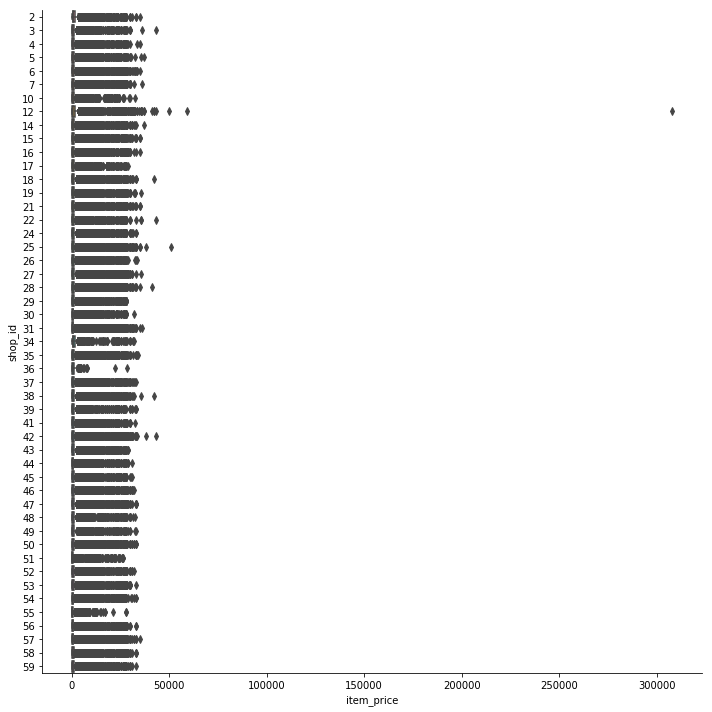

In [25]:
sns.catplot(x='item_price', y='shop_id', kind='box', orient='h', data=transactions, height=10)

In [26]:
print(transactions["item_price"].max())
transactions[transactions["item_price"] > 200000]

307980.0


,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
1163158,2013-12-13,11,12,6066,307980.0,1.0


In [27]:
#transactions[transactions["item_price"] > 200000]["item_id"].values[0]
items[items.item_id == transactions[transactions["item_price"] > 200000]["item_id"].values[0]]


,item_name,item_id,item_category_id
6066,Radmin 3 - 522 лиц.,6066,75


In [28]:
shops[shops.shop_id == 12]

,shop_name,shop_id
12,Интернет-магазин ЧС,12


This most expensive item is some vpn program for 522 persons. The price per one radmin is 590.

In [29]:
items[items["item_name"].apply(lambda x: "radmin" in x.lower().split() )]

,item_name,item_id,item_category_id
6065,Radmin 3 - 1 лиц.,6065,75
6066,Radmin 3 - 522 лиц.,6066,75


This item is also sold to one person. Let's see transactions for this item.

In [30]:
transactions[transactions.item_id==6065].head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
291238,2013-03-21,2,22,6065,1299.0,1.0
291260,2013-03-22,2,22,6065,1299.0,1.0
318708,2013-03-11,2,25,6065,1299.0,1.0
370177,2013-04-18,3,12,6065,1299.0,1.0
375067,2013-04-06,3,6,6065,1299.0,1.0


In [31]:
transactions[transactions.item_id==6065]["item_cnt_day"].sum()

39.0

In total, there were sold 39 Radmins with price 1299. So, I would just remove that single transactions that was probably sold to some organization.

In [32]:
print(transactions.shape)
transactions.drop(transactions[transactions.item_price>300000].index[0], axis=0, inplace=True)
print(transactions.shape)

(2884876, 6)
(2884875, 6)


Check transactions with price lower than 0

In [33]:
transactions[transactions["item_price"] <= 0]

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day


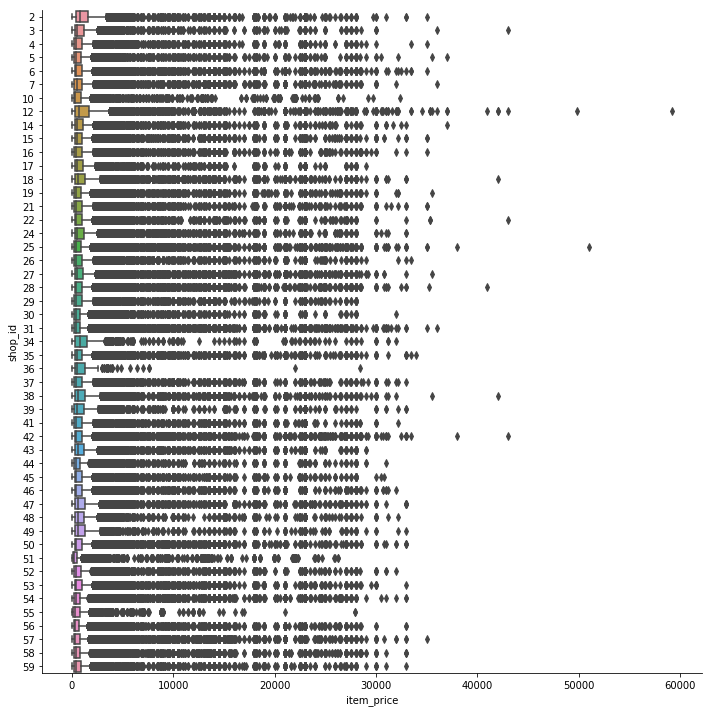

In [34]:
sns.catplot(x='item_price', y='shop_id', kind='box', orient='h', data=transactions, height=10)

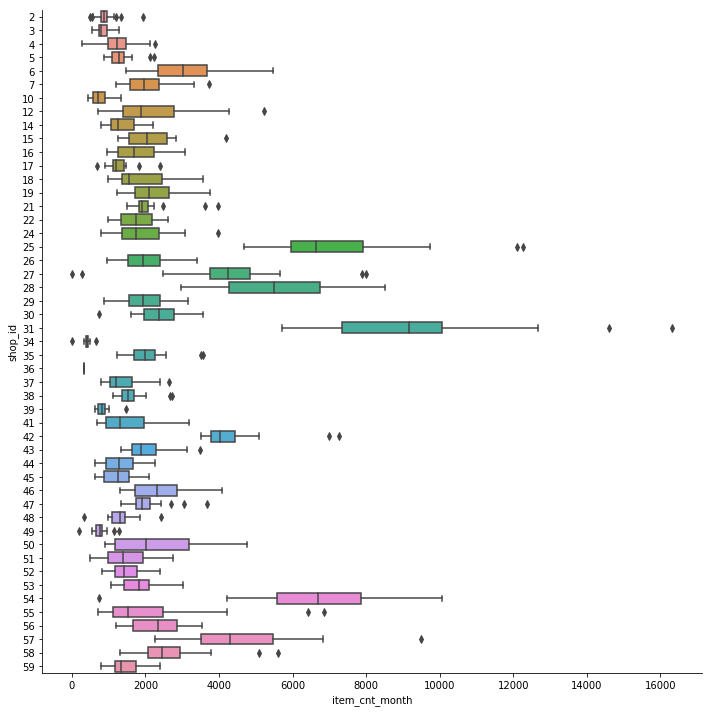

In [35]:
temp.rename(columns = {"item_cnt_day": "item_cnt_month"}, inplace=True)
sns.catplot(x='item_cnt_month', y='shop_id', kind='box', orient='h', data=temp, height=10)

In [36]:
transactions.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,2013-01-02,0,59,22154,999.000000,1.0
1,2013-01-03,0,25,2552,899.000000,1.0
2,2013-01-05,0,25,2552,899.000000,-1.0
3,2013-01-06,0,25,2554,1709.050049,1.0
4,2013-01-15,0,25,2555,1099.000000,1.0


### `6` Investigate Outliers
- price
- number of items sold each month

Calculate the low and high prices that corresponds to 1 and 99 percentile.

(21569,)

Text(0.5,1,'Distribution of item prices')

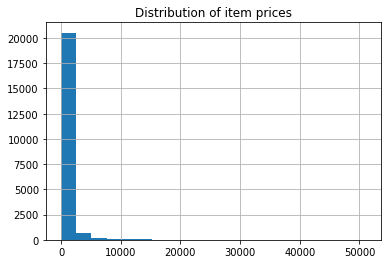

In [37]:
prices = pd.merge(items, transactions.groupby(["item_id"], as_index=False)["item_price"].mean(), how='inner').item_price
prices.shape
prices.hist(bins=20)
plt.title("Distribution of item prices")

In [38]:
low, high = np.percentile(prices, (1,99))
print(low, high)
print("Number of transactions outside of 1, 99 percentile range:")
print(transactions.query('item_price > @high | item_price < @low').shape[0])
print("Number of items outside of 1, 99 percentile range")
print((prices > high).sum() + (prices < low).sum())
#np.percentile?
#transactions.query?

28.0 7992.559999999998
Number of transactions outside of 1, 99 percentile range:
63909
Number of items outside of 1, 99 percentile range
389


34458 items with a price outside of 1,99 percentile range.

Here, we can either clip item prices to the 1 and 99 percentile or keep it as it is.

I will investigate how it will affect the score and decide later whether to clip the values.

In [39]:
transactions["item_price"] = np.clip(transactions.item_price, low, high)

In [40]:
#delete unused DataFrames

del prices
del temp
gc.collect()

65

### <a class="anchor" id="feature">Part II : Feature Engineering</a>




Since the competition task is to make a monthly prediction, we need to aggregate the data to montly level before doing any encodings.

Fist we need to group transactions by index_columns = ["date_block_num", "shop_id", "item_id"]. We can count number of items sold per month per shop_id, this eventually will be our target feature that we need to predict.
We also have date column, which can be transformed to two new features year and month. In addition, two feautures mean and variance of item_price per shop per block will be calcualted.


### `1` Cleaning function and by month aggregation
Create cleaning fucntion that will perform cleaning steps from EDA. Than, aggregate data by month.  
Similarly to test set, we will augment the train set with the missing number of combinations of shop_id and item_id in each block and fill it with 0.


In [228]:
transactions = pd.read_csv(os.path.join(DATA_FOLDER, 'sales_train.csv'))

In [229]:
def clean_transactions(df, clip_price=True, delete_closed_shops=True):
    """Clean transactions DataFrame: transform date into pandas datetime format, rename shop ids
    clip price values, delete_closed_shops and delete expensive items (price > 300000).
    
    Parameters
    ----------
    df : DataFrame
        DataFrame with transactions, "date" column is required  
        
    clip_price : boolean, default True
        Clip price value to (1,99) percentile
        
    delete_closed_shops : boolean, default True
        Delete shops that worked for a short period of time and doesn't present in test data base
        
    Returns
    -------
    df : DataFrame
        Cleaned DataFrame 
    
    """
    
    #transform date
    df["date"] = pd.to_datetime(df["date"], format="%d.%m.%Y")
    df["month"] = df.date.dt.month
    df["year"] = df.date.dt.year
    df["revenue"] = df["item_cnt_day"]*df["item_price"]
    
    #rename shop ids
    helper.rename_shop_ids(df)
    
    #remove expensive order
    df.drop(df[df.item_price>300000].index[0], axis=0, inplace=True)

    #delete shops that worked for a short time and were closed
    if delete_closed_shops:
        shops_to_delete = [8, 9, 13, 20, 23, 32, 33, 40]
        df.drop(df[df.shop_id.isin(shops_to_delete)].index, axis=0, inplace=True)
        
    #clip values to 1, 99 percentile
    if clip_price:
        prices = pd.merge(items, transactions.groupby(["item_id"], as_index=False)["item_price"].mean(), 
                          how='inner').item_price
        low, high = np.percentile(prices, (1,99))
        df["item_price"] = np.clip(df.item_price, low, high)
    
    return df

In [230]:
def generare_monthly_sales(df, col_names, clip_max_items=None):
    """Create new DataFrame with all shop_ids and item_ids combinations in each block aggregated by month
    
    Parameters
    ----------
    df : DataFrame
        DataFrame with transactions
    col_names : list of str
        List of column names which will be used to group data by month
   clip_max_items : int, default None 
        The highest value of items sold by month
        
    Returns
    -------
    full_df : DataFrame
        DataFrame with aggregated data by provided column augmented with 
        missing combinations of shops and items from train set
        
    """
    
    df = df.groupby(col_names, as_index=False).agg({"item_cnt_day": "sum", "revenue": "sum",
                                                        "item_price": ["mean", "var"]})

    df.columns = [col[0] if col[-1]=='' else '_'.join(col) for col in df.columns.values]
    
    df.rename(columns={"item_cnt_day_sum": "item_cnt_month", "revenue_sum": "revenue"}, inplace=True)
    
    #create new DataFrame with all shop_ids and item_ids combinations in each block
    full_df = []
    for block in df.date_block_num.unique():
        shop_ids = df.loc[df.date_block_num == block, "shop_id"].unique()
        item_ids = df.loc[df.date_block_num == block, "item_id"].unique()
        full_df.append(list(product([block], shop_ids, item_ids)))
    full_df = pd.DataFrame(np.vstack(full_df), columns =col_names)
    full_df = pd.merge(full_df, df, on=col_names, how='left')
    
    full_df["month"] = (full_df["date_block_num"] + 1) % 12
    full_df["year"] = np.floor((full_df["date_block_num"]) / 12 ).astype('int32') + 2013
    
    #full_df[["item_cnt_month", "revenue"]] = full_df[["item_cnt_month", "revenue"]].fillna(0)
    full_df[["item_cnt_month", "revenue"]] = full_df[["item_cnt_month", "revenue"]].fillna(0)
    full_df["item_price_var"] = full_df["item_price_var"].fillna(0)
    full_df["item_price_mean"] = full_df.groupby("item_id")["item_price_mean"].transform(lambda x: x.fillna(x.mean()))
    
    if clip_max_items:
        full_df["item_cnt_month"] = np.clip(full_df["item_cnt_month"], 0, clip_max_items)
    
    full_df = helper.downgrade_dtypes(full_df)
    
    return full_df

In [231]:
start = time.time()
index_cols = ["date_block_num", "shop_id", "item_id"]   

transactions = clean_transactions(transactions)

#Create Data Frame with shop_id item_id combinations aggregated by month
monthly_sales = generare_monthly_sales(transactions, index_cols, 20)
monthly_sales[8000000:8000010]
print("{:.2f} sec".format(time.time() - start))   

,date_block_num,shop_id,item_id,item_cnt_month,revenue,item_price_mean,item_price_var,month,year
8000000,24,2,10687,0.0,0.0,991.485107,0.0,1,2015
8000001,24,2,10701,0.0,0.0,299.000000,0.0,1,2015
8000002,24,2,10708,0.0,0.0,244.282059,0.0,1,2015
8000003,24,2,10763,0.0,0.0,679.324829,0.0,1,2015
8000004,24,2,10770,0.0,0.0,149.000000,0.0,1,2015
8000005,24,2,10893,0.0,0.0,2299.000000,0.0,1,2015
8000006,24,2,10940,0.0,0.0,1244.111084,0.0,1,2015
8000007,24,2,10945,0.0,0.0,291.119751,0.0,1,2015
8000008,24,2,11217,0.0,0.0,445.115967,0.0,1,2015
8000009,24,2,11254,0.0,0.0,218.087494,0.0,1,2015


30.22 sec


Next, I will prepare test data to merge it with train data in full_df

In [232]:
#number of blocks in train set
max_block = transactions.date_block_num.unique().max()

prep_test = test.copy()
prep_test["month"] = monthly_sales.month.values[-1] + 1
prep_test["year"] = monthly_sales.year.values[-1]
prep_test["date_block_num"] = monthly_sales.date_block_num.values[-1]+1

#add test data to full df
monthly_sales = pd.concat([monthly_sales, prep_test], sort=False).drop(["ID"], axis=1)
monthly_sales[["item_cnt_month", "revenue"]] = monthly_sales[["item_cnt_month", "revenue"]].fillna(0)
monthly_sales["item_price_var"] = monthly_sales["item_price_var"].fillna(0)
monthly_sales["item_price_mean"] = monthly_sales.groupby("item_id")["item_price_mean"].transform(lambda x: x.fillna(x.mean()))
    

monthly_sales.tail()

,date_block_num,shop_id,item_id,item_cnt_month,revenue,item_price_mean,item_price_var,month,year
214195,34,45,18454,0.0,0.0,180.539673,0.0,11,2015
214196,34,45,16188,0.0,0.0,1256.975952,0.0,11,2015
214197,34,45,15757,0.0,0.0,199.177567,0.0,11,2015
214198,34,45,19648,0.0,0.0,97.864647,0.0,11,2015
214199,34,45,969,0.0,0.0,475.883453,0.0,11,2015


In [233]:
monthly_sales.head()

,date_block_num,shop_id,item_id,item_cnt_month,revenue,item_price_mean,item_price_var,month,year
0,0,2,27,1.0,2499.0,2499.0,0.0,1,2013
1,0,2,33,1.0,499.0,499.0,0.0,1,2013
2,0,2,317,1.0,299.0,299.0,0.0,1,2013
3,0,2,438,1.0,299.0,299.0,0.0,1,2013
4,0,2,471,2.0,798.0,399.0,0.0,1,2013


#### Generate Submission #2 using numebr of items sold in previous month
From this dataframe I can get item_cnt_month simply by using filling forward operation on item_cnt_month.
Let's see what score I can get.

In [ ]:
start = time.time()

submission = monthly_sales[monthly_sales.date_block_num > 23].copy()
submission["item_cnt_month"] = submission.groupby(["shop_id","item_id"])["item_cnt_month"].fillna(method='ffill')
y_test = submission.loc[submission.date_block_num==34,"item_cnt_month"]
y_test.fillna(1, inplace=True)

print("{:.2f} sec".format(time.time() - start))  

In [97]:
helper.create_submission_csv('submission_ffill2.csv', submission[submission.date_block_num==34], y_test)

#delete unused DataFrames
del submission
del prep_test
gc.collect();

The score is 1.16276 which is an improvement in comparison with submission with "ones".

### `2` Feature engineering using shop, item and category names

Most of the shops have the city name encoded as a first word except "Цифровой", "Интернет-магазин" and "Выездная Торговля". The first shop is a stock place — a kind of online sale, and the second one is online sale shop,
the fird is seasonal moving shop. I will replace first two with the word "Online" in the city name and will keep the "Выездная Торговля"

In [234]:
shops["shop_name"].head()

0     !Якутск Орджоникидзе, 56 фран
1     !Якутск ТЦ "Центральный" фран
2                  Адыгея ТЦ "Мега"
3    Балашиха ТРК "Октябрь-Киномир"
4          Волжский ТЦ "Волга Молл"
Name: shop_name, dtype: object

The category name consist of two parts before and after "-". The name before is related to some macro category and name after is related to micro category. We can use this information two generate a new features.

In [235]:
item_categories["item_category_name"].head()

0    PC - Гарнитуры/Наушники
1           Аксессуары - PS2
2           Аксессуары - PS3
3           Аксессуары - PS4
4           Аксессуары - PSP
Name: item_category_name, dtype: object

In [236]:
def add_shop_item_cat_names(df, items=items, shops=shops, item_categories=item_categories):
    """Merge items, shops and categories to monthly sales DataFrame. 
    Extract city name and macro categories

    Parameters
    ----------
    df : DataFrame
        DataFrame with monthly sales
    items : DataFrame, default items
        DataFrame with item names
    shops : DataFrame, default shops
        DataFrame with shop names
    item_categories : DataFrame, default item_categories
        DataFrame with item_categories names

    Returns
    -------
    df : DataFrame
        Updated DataFrame

    """
    df = pd.merge(df, items, how='left')
    #print(df.columns)
    df = pd.merge(df, shops, how='left')
    df = pd.merge(df, item_categories, how='left')
    
    #create "city" feature
    df["city"] = df["shop_name"].apply(lambda x: x.strip("!").split()[0])
    df["city"] = df["city"].replace(["Цифровой","Интернет-магазин"] , ["Online", "Online"])
    
    #create macro_category feature
    df["macro_category"] = df["item_category_name"].apply(lambda x: x.split("-")[0].strip())
    df["macro_category"] = df["macro_category"].replace(["PC"], ["Игровые консоли"])
    
    df["micro_category"] = df["item_category_name"].apply(lambda x: x.split("-")[-1].strip())
    
    #drop original columns with names
    #df.drop(["item_name", "shop_name", "item_category_name"], axis=1, inplace=True)
    return df

monthly_sales = add_shop_item_cat_names(monthly_sales)

In [237]:
monthly_sales["city"].value_counts()

Москва          2285669
Тюмень           614265
Уфа              476044
Якутск           476044
Воронеж          476044
Самара           476044
Online           443573
СПб              422048
Красноярск       381285
РостовНаДону     363499
Н.Новгород       336247
Новосибирск      248403
Чехов            238022
Адыгея           238022
Казань           238022
Калуга           238022
Волжский         238022
Сергиев          238022
Жуковский        238022
Ярославль        238022
Балашиха         238022
Сургут           238022
Омск             238022
Коломна          238022
Курск            238022
Вологда          229982
Химки            201626
Томск            118343
Name: city, dtype: int64

In [238]:
monthly_sales["macro_category"].value_counts()

Кино                                 3970980
Музыка                               2322114
Подарки                              1395006
Игры PC                               913825
Игры                                  896417
Книги                                 563534
Программы                             322345
Аксессуары                            141504
Игровые консоли                        61803
Карты оплаты                           21811
Доставка товара                         9390
Элементы питания                        7178
Карты оплаты (Кино, Музыка, Игры)       4428
Чистые носители (штучные)               3811
Служебные                               3127
Чистые носители (шпиль)                 2443
Билеты (Цифра)                          2178
Игры Android                            1098
Игры MAC                                 410
Name: macro_category, dtype: int64

In [239]:
monthly_sales["micro_category"].value_counts().head()

DVD                           2412831
CD локального производства    1516769
Ray                           1112222
Цифра                          436340
PS3                            390224
Name: micro_category, dtype: int64

In [240]:
##create dictionary of column encoders
label_dict = defaultdict(LabelEncoder)

# Encoding the variable
enc_cols = ["macro_category","micro_category", "city"]
monthly_sales[enc_cols] = monthly_sales[enc_cols].apply(lambda x: label_dict[x.name].fit_transform(x))

# Inverse the encoded
#full_df[enc_cols].apply(lambda x: label_dict[x.name].inverse_transform(x))

# Using the dictionary to label future data
#full_df[enc_cols].apply(lambda x: label_dict[x.name].transform(x))

monthly_sales.head()

,date_block_num,shop_id,item_id,item_cnt_month,revenue,item_price_mean,item_price_var,month,year,item_name,item_category_id,shop_name,item_category_name,city,macro_category,micro_category
0,0,2,27,1.0,2499.0,2499.0,0.0,1,2013,"007 Legends [PS3, русская версия]",19,"Адыгея ТЦ ""Мега""",Игры - PS3,1,4,9
1,0,2,33,1.0,499.0,499.0,0.0,1,2013,1+1 (BD),37,"Адыгея ТЦ ""Мега""",Кино - Blu-Ray,1,10,14
2,0,2,317,1.0,299.0,299.0,0.0,1,2013,1С:Аудиокниги. Мединский В. Мифы о России. О р...,45,"Адыгея ТЦ ""Мега""",Книги - Аудиокниги 1С,1,11,25
3,0,2,438,1.0,299.0,299.0,0.0,1,2013,1С:Аудиотеатр. Лучшие произведения русских пис...,45,"Адыгея ТЦ ""Мега""",Книги - Аудиокниги 1С,1,11,25
4,0,2,471,2.0,798.0,399.0,0.0,1,2013,1С:Бухгалтерия 8 (ред.3.0) как на ладони. Изд ...,49,"Адыгея ТЦ ""Мега""",Книги - Методические материалы 1С,1,11,41


In [241]:
monthly_sales = helper.downgrade_dtypes(monthly_sales)

#write monthly_sales to pickle
monthly_sales.to_pickle('monthly_sales_clip20.pkl')

In [242]:
monthly_sales.isnull().sum()

date_block_num            0
shop_id                   0
item_id                   0
item_cnt_month            0
revenue                   0
item_price_mean       16086
item_price_var            0
month                     0
year                      0
item_name                 0
item_category_id          0
shop_name                 0
item_category_name        0
city                      0
macro_category            0
micro_category            0
dtype: int64

### `3` Feature engineering using time lag operator
Use different range of months for feature engineering 1, 2, 4, and 12 months.  
Use different groupby columns combinations for time lag generation.

In [243]:
monthly_sales = pd.read_pickle('monthly_sales_clip20.pkl')

In [244]:
def create_lag_features(df, group_by_cols, lags, lag_cols):
    """Create time lag features
    
    Parameters
    ----------
    df : DataFrame
        DataFrame with monthly aggregated data
    group_by_cols : list of str
        List of column names which is used for group by
    lags : list of int
        List of time lag ranges
    lag_cols : list of str
        List of column names which will be used for time lag feature generations
    
    Returns
    -------
    df : DataFrame
        Updated DataFrame
        
    """
    cols = group_by_cols + lag_cols
    for lag in lags:
        print("group by coumns / lag_columns / lag range")
        print(group_by_cols, "/", lag_cols, "/", lag)
        tmp = df[cols].copy()
        tmp["date_block_num"] += lag
        tmp = tmp[group_by_cols + lag_cols]
        #tmp.columns = group_by_cols + [col+"_lag_"+str(lag) for col in lag_cols]
        tmp = tmp.groupby(group_by_cols, as_index=False)[lag_cols].agg('sum')
        tmp.columns = group_by_cols + ['_'.join(group_by_cols[1:]) +"_"+col+"_lag_"+str(lag) for col in lag_cols]
        df = pd.merge(df, tmp, on=group_by_cols, how='left')
    del tmp
    gc.collect()
    return df

In [245]:
start = time.time()
lags = [1, 2, 4, 12]
lag_cols = ["item_cnt_month", "revenue"]
monthly_sales = create_lag_features(monthly_sales, ["date_block_num", "shop_id", "item_id"], lags, lag_cols)
monthly_sales = create_lag_features(monthly_sales, ["date_block_num", "item_id"], lags, ["item_cnt_month"])
#monthly_sales = create_lag_features(monthly_sales, ["date_block_num", "shop_id"], lags, ["item_cnt_month"])
monthly_sales = create_lag_features(monthly_sales, ["date_block_num", "shop_id", "item_category_id"], lags, lag_cols)
monthly_sales = create_lag_features(monthly_sales, ["date_block_num", "city","item_id"], [1,2], ["item_cnt_month"])
monthly_sales = create_lag_features(monthly_sales, ["date_block_num", "item_category_id"], lags, lag_cols)
monthly_sales = create_lag_features(monthly_sales, ["date_block_num", "macro_category"], lags, lag_cols)
monthly_sales = create_lag_features(monthly_sales, ["date_block_num", "micro_category"], lags, lag_cols)
print("{:.2f} sec".format(time.time() - start)) 

group by coumns / lag_columns / lag range
['date_block_num', 'shop_id', 'item_id'] / ['item_cnt_month', 'revenue'] / 1
group by coumns / lag_columns / lag range
['date_block_num', 'shop_id', 'item_id'] / ['item_cnt_month', 'revenue'] / 2
group by coumns / lag_columns / lag range
['date_block_num', 'shop_id', 'item_id'] / ['item_cnt_month', 'revenue'] / 4
group by coumns / lag_columns / lag range
['date_block_num', 'shop_id', 'item_id'] / ['item_cnt_month', 'revenue'] / 12
group by coumns / lag_columns / lag range
['date_block_num', 'item_id'] / ['item_cnt_month'] / 1
group by coumns / lag_columns / lag range
['date_block_num', 'item_id'] / ['item_cnt_month'] / 2
group by coumns / lag_columns / lag range
['date_block_num', 'item_id'] / ['item_cnt_month'] / 4
group by coumns / lag_columns / lag range
['date_block_num', 'item_id'] / ['item_cnt_month'] / 12
group by coumns / lag_columns / lag range
['date_block_num', 'shop_id', 'item_category_id'] / ['item_cnt_month', 'revenue'] / 1
group 

In [246]:
monthly_sales.columns

Index(['date_block_num', 'shop_id', 'item_id', 'item_cnt_month', 'revenue',
       'item_price_mean', 'item_price_var', 'month', 'year', 'item_name',
       'item_category_id', 'shop_name', 'item_category_name', 'city',
       'macro_category', 'micro_category',
       'shop_id_item_id_item_cnt_month_lag_1', 'shop_id_item_id_revenue_lag_1',
       'shop_id_item_id_item_cnt_month_lag_2', 'shop_id_item_id_revenue_lag_2',
       'shop_id_item_id_item_cnt_month_lag_4', 'shop_id_item_id_revenue_lag_4',
       'shop_id_item_id_item_cnt_month_lag_12',
       'shop_id_item_id_revenue_lag_12', 'item_id_item_cnt_month_lag_1',
       'item_id_item_cnt_month_lag_2', 'item_id_item_cnt_month_lag_4',
       'item_id_item_cnt_month_lag_12',
       'shop_id_item_category_id_item_cnt_month_lag_1',
       'shop_id_item_category_id_revenue_lag_1',
       'shop_id_item_category_id_item_cnt_month_lag_2',
       'shop_id_item_category_id_revenue_lag_2',
       'shop_id_item_category_id_item_cnt_month_lag_4',

There are many Nans in the first 12 blocks because we shifted the values down along the columns. I will remove first 12 blocks.

In [247]:
monthly_sales = monthly_sales[monthly_sales.date_block_num > 11]

In [248]:
monthly_sales.head()

,date_block_num,shop_id,item_id,item_cnt_month,revenue,item_price_mean,item_price_var,month,year,item_name,...,macro_category_item_cnt_month_lag_12,macro_category_revenue_lag_12,micro_category_item_cnt_month_lag_1,micro_category_revenue_lag_1,micro_category_item_cnt_month_lag_2,micro_category_revenue_lag_2,micro_category_item_cnt_month_lag_4,micro_category_revenue_lag_4,micro_category_item_cnt_month_lag_12,micro_category_revenue_lag_12
4233996,12,2,32,1.0,119.0,119.0,0.0,1,2014,1+1,...,38955.0,14322877.0,26527.0,7710717.5,23107.0,6798674.5,21646.0,5925206.0,29950.0,8279159.00
4233997,12,2,33,1.0,199.0,199.0,0.0,1,2014,1+1 (BD),...,38955.0,14322877.0,9838.0,4181316.5,7340.0,3468346.5,7517.0,3388386.5,5750.0,2738841.00
4233998,12,2,99,1.0,149.0,149.0,0.0,1,2014,1812: УЛАНСКАЯ БАЛЛАДА (BD),...,38955.0,14322877.0,9838.0,4181316.5,7340.0,3468346.5,7517.0,3388386.5,5750.0,2738841.00
4233999,12,2,482,2.0,6600.0,3300.0,0.0,1,2014,1С:Бухгалтерия 8. Базовая версия,...,3710.0,5614961.0,411.0,853355.0,459.0,822176.0,502.0,965084.0,639.0,1259317.25
4234000,12,2,485,1.0,300.0,300.0,0.0,1,2014,1С:Бухгалтерия 8. Учебная версия. Издание 7.,...,3710.0,5614961.0,411.0,853355.0,459.0,822176.0,502.0,965084.0,639.0,1259317.25


In [249]:
monthly_sales.isnull().sum()

date_block_num                                          0
shop_id                                                 0
item_id                                                 0
item_cnt_month                                          0
revenue                                                 0
item_price_mean                                     16086
item_price_var                                          0
month                                                   0
year                                                    0
item_name                                               0
item_category_id                                        0
shop_name                                               0
item_category_name                                      0
city                                                    0
macro_category                                          0
micro_category                                          0
shop_id_item_id_item_cnt_month_lag_1              1315080
shop_id_item_i

In [250]:
#fill missing values with 0 for "*count*" or "*revenue* columns and with mean values for "*price*" columns 
for col in monthly_sales.columns:
    if 'item_cnt' in col or 'revenue' in col:
        monthly_sales[col]=monthly_sales[col].fillna(0)
    elif 'item_price' in col:
        monthly_sales[col]=monthly_sales[col].fillna(monthly_sales[col].mean())

In [251]:
monthly_sales.to_pickle('monthly_sales_clip20_after_lags.pkl')

### `4`  Mean encodings using K-fold regularization scheme
Here, I will create new features using mean encoding scheme.  

In [263]:
monthly_sales = pd.read_pickle('monthly_sales_clip20_after_lags.pkl')

In [264]:
def create_mean_encode_features_KFold(df, group_cols, agg_cols, agg_func, n_splits=6):
    """Create mean encoded features using K-Fold regularization
    
    Parameters
    ----------
    df : DataFrame
        DataFrame with monthly data
    group_cols : list of str
        List of column names which is used for group by
    agg_cols : list of str
        List of columns for aggregation using function specified in agg_func
    agg_func : str
        Function that will be applied for aggregation
    n_splits : int
        Number of K-Fold splits
        
    Returns
    -------
    df : DataFrame
        Updated DataFrame
    
    """
    kf = KFold(n_splits=n_splits, random_state=142, shuffle=False)

    new_names = []
    for col in agg_cols:
        new_names.append('_'.join(group_cols).replace("_id","") + "_id_" + col + "_" + agg_func)
    
    for name in new_names:
        df[name] = np.nan

    for train, val in kf.split(df):
        X_train = df.iloc[train]
        X_val = df.iloc[val]
        group = X_train.groupby(group_cols, as_index=False)[agg_cols].agg(agg_func)
        tmp_names = list(range(len(agg_cols)))
        group.columns = group_cols + tmp_names
        X_val = pd.merge(X_val.reset_index(), group, on=group_cols, how='left').set_index("index")[tmp_names]
        df.loc[X_val.index, new_names] = X_val.values

    #fill missing values by means
    for col in new_names: 
        df[col].fillna(df[col].mean(), inplace=True)
    return df

In [265]:
#With regularization 8052177210  
start = time.time()
#group_cols = ["shop_id", "item_id"]
#agg_cols = ["item_cnt_month", "item_price_mean"]
#agg_func = 'mean'
monthly_sales = create_mean_encode_features_KFold(monthly_sales, ["item_id"], 
                                                  ["item_cnt_month", "item_price_mean"],'mean')
monthly_sales = create_mean_encode_features_KFold(monthly_sales, ["shop_id"],
                                                  ["item_cnt_month"], 'mean')
monthly_sales = create_mean_encode_features_KFold(monthly_sales, ["shop_id","item_id"],
                                                  ["item_cnt_month", "item_price_mean"], 'mean')

monthly_sales = create_mean_encode_features_KFold(monthly_sales, ["item_category_id","item_id"],
                                                  ["item_cnt_month"], 'mean')
monthly_sales = create_mean_encode_features_KFold(monthly_sales, ["city","item_id"], 
                                                  ["item_cnt_month", "item_price_mean"], 'mean')

monthly_sales = create_mean_encode_features_KFold(monthly_sales, ["date_block_num","item_id"], 
                                                  ["item_cnt_month"],'mean')
monthly_sales = create_mean_encode_features_KFold(monthly_sales, ["micro_category"], 
                                                  ["item_cnt_month"],'mean')
monthly_sales = create_mean_encode_features_KFold(monthly_sales, ["macro_category"], 
                                                  ["item_cnt_month"],'mean')

#monthly_sales = create_mean_encode_features_KFold(monthly_sales, ["item_id"], ["item_cnt_month"], 'sum')
#monthly_sales = create_mean_encode_features_KFold(["shop_id"], ["item_cnt_month"], 'sum')
#monthly_sales = create_mean_encode_features_KFold(["shop_id","item_id"], ["item_cnt_month"], 'sum')

print("{:.2f} sec".format(time.time() - start))         
monthly_sales.head()

201.59 sec


,date_block_num,shop_id,item_id,item_cnt_month,revenue,item_price_mean,item_price_var,month,year,item_name,...,item_id_item_price_mean_mean,shop_id_item_cnt_month_mean,shop_item_id_item_cnt_month_mean,shop_item_id_item_price_mean_mean,item_category_item_id_item_cnt_month_mean,city_item_id_item_cnt_month_mean,city_item_id_item_price_mean_mean,date_block_num_item_id_item_cnt_month_mean,micro_category_id_item_cnt_month_mean,macro_category_id_item_cnt_month_mean
4233996,12,2,32,1.0,119.0,119.0,0.0,1,2014,1+1,...,195.413162,0.142079,0.473684,198.239655,0.593333,0.473684,198.239655,0.243242,0.237221,0.203883
4233997,12,2,33,1.0,199.0,199.0,0.0,1,2014,1+1 (BD),...,230.472183,0.142079,0.315789,228.889709,0.350000,0.315789,228.889709,0.243242,0.165200,0.203883
4233998,12,2,99,1.0,149.0,149.0,0.0,1,2014,1812: УЛАНСКАЯ БАЛЛАДА (BD),...,132.291397,0.142079,0.000000,131.501785,0.059190,0.000000,131.501785,0.243242,0.165200,0.203883
4233999,12,2,482,2.0,6600.0,3300.0,0.0,1,2014,1С:Бухгалтерия 8. Базовая версия,...,3207.083496,0.142079,0.578947,3237.718262,1.277778,0.578947,3237.718262,0.243242,0.356201,0.158682
4234000,12,2,485,1.0,300.0,300.0,0.0,1,2014,1С:Бухгалтерия 8. Учебная версия. Издание 7.,...,292.563965,0.142079,0.428571,295.723053,1.536585,0.428571,295.723053,0.243242,0.356201,0.158682


In [266]:
import joblib
joblib.dump(monthly_sales,'monthly_sales_clip20_after_means.pkl')

['monthly_sales_clip20_after_means.pkl']

### <a class="anchor" id="XGboost">Part III : XGBoost model</a>

In [267]:
import joblib
monthly_sales = joblib.load('monthly_sales_clip20_after_means.pkl')

In [268]:
#monthly_sales.isnull().sum()
monthly_sales.columns

Index(['date_block_num', 'shop_id', 'item_id', 'item_cnt_month', 'revenue',
       'item_price_mean', 'item_price_var', 'month', 'year', 'item_name',
       'item_category_id', 'shop_name', 'item_category_name', 'city',
       'macro_category', 'micro_category',
       'shop_id_item_id_item_cnt_month_lag_1', 'shop_id_item_id_revenue_lag_1',
       'shop_id_item_id_item_cnt_month_lag_2', 'shop_id_item_id_revenue_lag_2',
       'shop_id_item_id_item_cnt_month_lag_4', 'shop_id_item_id_revenue_lag_4',
       'shop_id_item_id_item_cnt_month_lag_12',
       'shop_id_item_id_revenue_lag_12', 'item_id_item_cnt_month_lag_1',
       'item_id_item_cnt_month_lag_2', 'item_id_item_cnt_month_lag_4',
       'item_id_item_cnt_month_lag_12',
       'shop_id_item_category_id_item_cnt_month_lag_1',
       'shop_id_item_category_id_revenue_lag_1',
       'shop_id_item_category_id_item_cnt_month_lag_2',
       'shop_id_item_category_id_revenue_lag_2',
       'shop_id_item_category_id_item_cnt_month_lag_4',

### Drop columns that will not be used in Gboost

In [269]:
drop_columns = ["city", "shop_id", "item_price_mean","city_item_id_item_price_mean_mean",
                "item_price_var", "shop_name", "item_name", "shop_item_id_item_price_mean_mean",
                "city_item_id_item_cnt_month_mean", "revenue",
                "item_category_name", "year", "micro_category", "macro_category"]
monthly_sales.drop(drop_columns, axis=1, inplace=True)

joblib.dump(monthly_sales,'monthly_sales_XGboost.pkl')

['monthly_sales_XGboost.pkl']

In [270]:
# for col in full_df.monthly_sales:
#     full_df[col]=full_df[col].fillna(full_df[col].mean())
monthly_sales.tail()

,date_block_num,item_id,item_cnt_month,month,item_category_id,shop_id_item_id_item_cnt_month_lag_1,shop_id_item_id_revenue_lag_1,shop_id_item_id_item_cnt_month_lag_2,shop_id_item_id_revenue_lag_2,shop_id_item_id_item_cnt_month_lag_4,...,micro_category_item_cnt_month_lag_12,micro_category_revenue_lag_12,item_id_item_cnt_month_mean,item_id_item_price_mean_mean,shop_id_item_cnt_month_mean,shop_item_id_item_cnt_month_mean,item_category_item_id_item_cnt_month_mean,date_block_num_item_id_item_cnt_month_mean,micro_category_id_item_cnt_month_mean,macro_category_id_item_cnt_month_mean
10643397,34,18454,0.0,11,55,1.0,99.0,0.0,0.0,0.0,...,9691.0,2899334.75,1.529231,184.805283,0.160859,1.142857,1.529231,0.243242,0.233949,0.179489
10643398,34,16188,0.0,11,64,0.0,0.0,0.0,0.0,0.0,...,1239.0,1188294.50,0.295240,724.553467,0.160859,0.298576,0.295240,0.243242,0.322974,0.298382
10643399,34,15757,0.0,11,55,0.0,0.0,0.0,0.0,0.0,...,9691.0,2899334.75,0.237812,199.272873,0.160859,0.222222,0.237812,0.243242,0.233949,0.179489
10643400,34,19648,0.0,11,40,0.0,0.0,0.0,0.0,0.0,...,14527.0,4015045.50,0.129630,97.973701,0.160859,0.000000,0.129630,0.243242,0.246266,0.210057
10643401,34,969,0.0,11,37,0.0,0.0,0.0,0.0,0.0,...,5171.0,2443222.00,0.464812,480.432434,0.160859,0.384615,0.464812,0.243242,0.165135,0.210057


### Split data_set to the train and validation set.

In [271]:
X_train = monthly_sales[monthly_sales['date_block_num']<33]
X_val = monthly_sales[monthly_sales['date_block_num']==33]
X_test = monthly_sales[monthly_sales['date_block_num']==34]

X_train, y_train = helper.get_X_y(X_train, "item_cnt_month")
X_val, y_val = helper.get_X_y(X_val, "item_cnt_month")
X_test, y_test = helper.get_X_y(X_test, "item_cnt_month")

In [273]:
X_test.head()

,date_block_num,item_id,month,item_category_id,shop_id_item_id_item_cnt_month_lag_1,shop_id_item_id_revenue_lag_1,shop_id_item_id_item_cnt_month_lag_2,shop_id_item_id_revenue_lag_2,shop_id_item_id_item_cnt_month_lag_4,shop_id_item_id_revenue_lag_4,...,micro_category_item_cnt_month_lag_12,micro_category_revenue_lag_12,item_id_item_cnt_month_mean,item_id_item_price_mean_mean,shop_id_item_cnt_month_mean,shop_item_id_item_cnt_month_mean,item_category_item_id_item_cnt_month_mean,date_block_num_item_id_item_cnt_month_mean,micro_category_id_item_cnt_month_mean,macro_category_id_item_cnt_month_mean
10429202,34,5037,11,19,0.0,0.0,1.0,749.5,1.0,1499.0,...,6423.0,13514972.00,2.046908,2139.718750,0.193491,0.818182,2.046908,0.243242,0.579551,0.644541
10429203,34,5320,11,55,0.0,0.0,0.0,0.0,0.0,0.0,...,9691.0,2899334.75,0.295240,724.553467,0.193491,0.298576,0.295240,0.243242,0.233949,0.179489
10429204,34,5233,11,19,1.0,1199.0,3.0,2997.0,0.0,0.0,...,6423.0,13514972.00,1.500000,806.312561,0.193491,1.250000,1.500000,0.243242,0.579551,0.644541
10429205,34,5232,11,23,0.0,0.0,0.0,0.0,0.0,0.0,...,5850.0,11357141.00,0.295240,724.553467,0.193491,0.298576,0.295240,0.243242,0.623866,0.644541
10429206,34,5268,11,20,0.0,0.0,0.0,0.0,0.0,0.0,...,10122.0,57157708.00,0.295240,724.553467,0.193491,0.298576,0.295240,0.243242,1.632672,0.644541


### XGboost with restricted hyperparameters

In [276]:
start = time.time()

model = XGBRegressor(
    max_depth=7,
    n_estimators=50,
    min_child_weight=300, 
    colsample_bytree=0.8, 
    subsample=0.8, 
    eta=0.3,    
    seed=142)


model.fit(
    X_train, 
    y_train, 
    eval_metric="rmse", 
    eval_set=[(X_train, y_train), (X_val, y_val)], 
    verbose=True, 
    early_stopping_rounds = 10)

time.time() - start

[13:26:25] Tree method is automatically selected to be 'approx' for faster speed. To use old behavior (exact greedy algorithm on single machine), set tree_method to 'exact'.
[0]	validation_0-rmse:1.15944	validation_1-rmse:1.0685
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 10 rounds.
[1]	validation_0-rmse:1.10915	validation_1-rmse:1.03553
[2]	validation_0-rmse:1.06725	validation_1-rmse:1.00561
[3]	validation_0-rmse:1.03013	validation_1-rmse:0.980679
[4]	validation_0-rmse:0.99746	validation_1-rmse:0.962091
[5]	validation_0-rmse:0.970197	validation_1-rmse:0.944831
[6]	validation_0-rmse:0.947248	validation_1-rmse:0.932045
[7]	validation_0-rmse:0.926368	validation_1-rmse:0.919936
[8]	validation_0-rmse:0.910324	validation_1-rmse:0.908391
[9]	validation_0-rmse:0.895078	validation_1-rmse:0.899354
[10]	validation_0-rmse:0.883544	validation_1-rmse:0.891589
[11]	validation_0-rmse:0.87219	valida

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.8, eta=0.3, gamma=0, learning_rate=0.1,
       max_delta_step=0, max_depth=7, min_child_weight=300, missing=None,
       n_estimators=50, n_jobs=1, nthread=None, objective='reg:linear',
       random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=142, silent=True, subsample=0.8)

3512.4943318367004

In [277]:
y_test = model.predict(X_test).clip(0,20)

In [278]:
from sklearn.externals import joblib
joblib.dump(model, "xgboost50_clip20.joblib.dat")

['xgboost50_clip20.joblib.dat']

In [279]:
from sklearn.externals import joblib
mm = joblib.load("xgboost50_clip20.joblib.dat")

In [280]:
helper.create_submission_csv("submission_xgboost50_clip20.csv", test, y_test)

This submission resulted in 0.98323 score

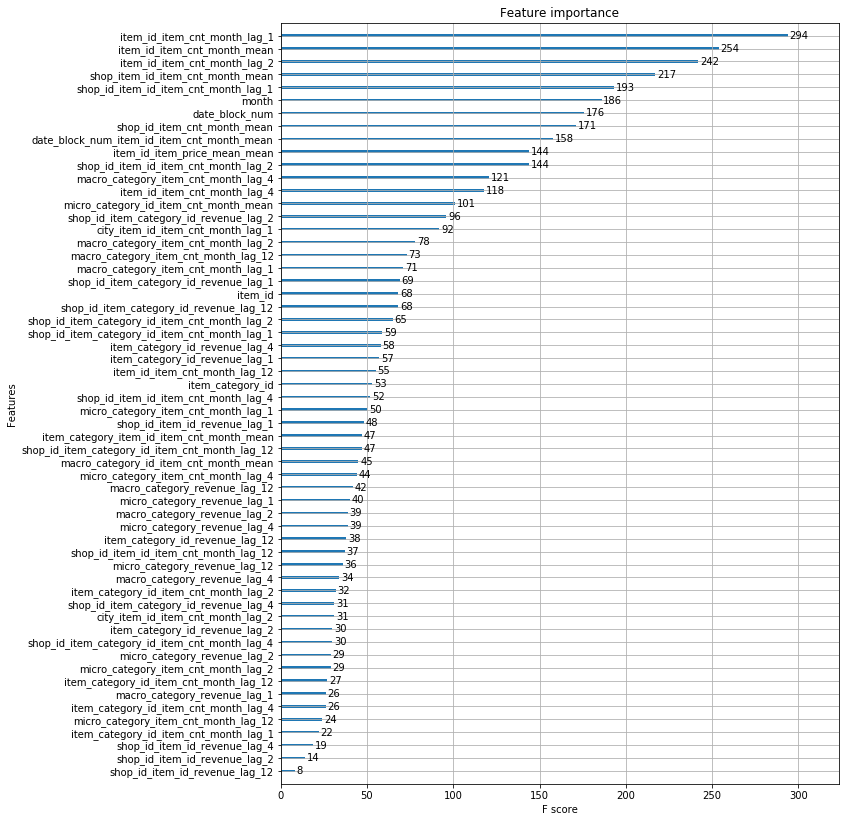

In [281]:
def plot_feature_importances(model, figsize=(10,14)):    
    fig, ax = plt.subplots(1,1,figsize=figsize)
    return plot_importance(booster=model, ax=ax)
plot_feature_importances(mm)

### Continue model training

In [290]:
# params = [('max_depth', 7), ('eval_metric', 'rmse'), ('verbose', True)]
# train = (X_train, y_train)
# watchlist = [((X_train, y_train), 'train'), ((X_val, y_val), "test")]
# bst = xgb.train(params, train, 1, watchlist , xgb_model=mm)

### Fitting of hyperparameters

#### Create indexes for cross-validation of 1 split 

We will use custom cross validation because we are working with time series, so the validation set should contain the data from specific block of dates. 

The following date block numbers are used in train and validation sets:  
    train1 < 33 and val1 = 33  

In [333]:
import joblib
monthly_sales = joblib.load('monthly_sales_XGboost.pkl')
monthly_sales = monthly_sales.reset_index().drop("index", axis=1)

In [334]:
cv_train = monthly_sales[monthly_sales["date_block_num"] < 33].index
cv_val= monthly_sales[monthly_sales["date_block_num"] == 33].index
cv = zip([cv_train],[cv_val])

In [335]:
X_val = monthly_sales[monthly_sales['date_block_num']==33]
X_test = monthly_sales[monthly_sales['date_block_num']==34]
X_val, y_val = helper.get_X_y(X_val, "item_cnt_month")
X_test, y_test = helper.get_X_y(X_test, "item_cnt_month")

In [336]:
param_test = {
    'max_depth': [7,8],
    'min_child_weight': [200,300]
}

#     'n_estimators' : [50],
#     'colsample_bytree' : [0.8], 
#     'subsample' :  [0.8], 
#     'eta' :  [0.3],    
#     'seed' : [142]

fit_params = { 
    'eval_metric' : "rmse", 
    'eval_set' : [(X_val, y_val)],
    'verbose' : True, 
    'early_stopping_rounds' : 10
}

gs = GridSearchCV(estimator = XGBRegressor(n_estimators=50, min_child_weight=300, colsample_bytree=0.8, 
                                                 subsample=0.8, eta=0.3, seed=142), 
                  param_grid = param_test,
                  fit_params=fit_params,
                  scoring='neg_mean_squared_error', 
                  cv=cv, 
                  verbose=4)

In [337]:
y = monthly_sales["item_cnt_month"]
X = monthly_sales.drop("item_cnt_month", axis=1)

In [338]:
gs.fit(X,y)

/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:643: DeprecationWarning: "fit_params" as a constructor argument was deprecated in version 0.19 and will be removed in version 0.21. Pass fit parameters to the "fit" method instead.
  '"fit" method instead.', DeprecationWarning)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/anaconda3/lib/python3.7/site-packages/sklearn/utils/__init__.py:202: FutureWarning: Int64Index.flags is deprecated and will be removed in a future version
  indices = indices if indices.flags.writeable else indices.copy()


Fitting 1 folds for each of 4 candidates, totalling 4 fits
[CV] max_depth=7, min_child_weight=200 ...............................
[15:45:29] Tree method is automatically selected to be 'approx' for faster speed. To use old behavior (exact greedy algorithm on single machine), set tree_method to 'exact'.
[0]	validation_0-rmse:1.06868
Will train until validation_0-rmse hasn't improved in 10 rounds.
[1]	validation_0-rmse:1.0355
[2]	validation_0-rmse:1.00565
[3]	validation_0-rmse:0.980217
[4]	validation_0-rmse:0.960644
[5]	validation_0-rmse:0.945089
[6]	validation_0-rmse:0.932549
[7]	validation_0-rmse:0.921332
[8]	validation_0-rmse:0.911248
[9]	validation_0-rmse:0.903752
[10]	validation_0-rmse:0.895114
[11]	validation_0-rmse:0.887639
[12]	validation_0-rmse:0.883248
[13]	validation_0-rmse:0.879023
[14]	validation_0-rmse:0.875872
[15]	validation_0-rmse:0.869343
[16]	validation_0-rmse:0.866122
[17]	validation_0-rmse:0.864156
[18]	validation_0-rmse:0.859971
[19]	validation_0-rmse:0.858209
[20]	

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed: 53.1min remaining:    0.0s


[CV] max_depth=7, min_child_weight=300 ...............................


/anaconda3/lib/python3.7/site-packages/sklearn/utils/__init__.py:202: FutureWarning: Int64Index.flags is deprecated and will be removed in a future version
  indices = indices if indices.flags.writeable else indices.copy()


[16:38:29] Tree method is automatically selected to be 'approx' for faster speed. To use old behavior (exact greedy algorithm on single machine), set tree_method to 'exact'.
[0]	validation_0-rmse:1.0685
Will train until validation_0-rmse hasn't improved in 10 rounds.
[1]	validation_0-rmse:1.03553
[2]	validation_0-rmse:1.00561
[3]	validation_0-rmse:0.980679
[4]	validation_0-rmse:0.962091
[5]	validation_0-rmse:0.944831
[6]	validation_0-rmse:0.932045
[7]	validation_0-rmse:0.919936
[8]	validation_0-rmse:0.908391
[9]	validation_0-rmse:0.899354
[10]	validation_0-rmse:0.891589
[11]	validation_0-rmse:0.886339
[12]	validation_0-rmse:0.882365
[13]	validation_0-rmse:0.87744
[14]	validation_0-rmse:0.873646
[15]	validation_0-rmse:0.868955
[16]	validation_0-rmse:0.865124
[17]	validation_0-rmse:0.863163
[18]	validation_0-rmse:0.860116
[19]	validation_0-rmse:0.857809
[20]	validation_0-rmse:0.856585
[21]	validation_0-rmse:0.854743
[22]	validation_0-rmse:0.853872
[23]	validation_0-rmse:0.852523
[24]	val

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed: 104.7min remaining:    0.0s


[CV] max_depth=8, min_child_weight=200 ...............................


/anaconda3/lib/python3.7/site-packages/sklearn/utils/__init__.py:202: FutureWarning: Int64Index.flags is deprecated and will be removed in a future version
  indices = indices if indices.flags.writeable else indices.copy()


[17:30:07] Tree method is automatically selected to be 'approx' for faster speed. To use old behavior (exact greedy algorithm on single machine), set tree_method to 'exact'.
[0]	validation_0-rmse:1.06743
Will train until validation_0-rmse hasn't improved in 10 rounds.
[1]	validation_0-rmse:1.0334
[2]	validation_0-rmse:1.00343
[3]	validation_0-rmse:0.976303
[4]	validation_0-rmse:0.956104
[5]	validation_0-rmse:0.93872
[6]	validation_0-rmse:0.925723
[7]	validation_0-rmse:0.91267
[8]	validation_0-rmse:0.901941
[9]	validation_0-rmse:0.892812
[10]	validation_0-rmse:0.88524
[11]	validation_0-rmse:0.879141
[12]	validation_0-rmse:0.875174
[13]	validation_0-rmse:0.869136
[14]	validation_0-rmse:0.86528
[15]	validation_0-rmse:0.859962
[16]	validation_0-rmse:0.856498
[17]	validation_0-rmse:0.854646
[18]	validation_0-rmse:0.851891
[19]	validation_0-rmse:0.850112
[20]	validation_0-rmse:0.846134
[21]	validation_0-rmse:0.844085
[22]	validation_0-rmse:0.843383
[23]	validation_0-rmse:0.842675
[24]	valida

[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed: 162.4min remaining:    0.0s


[CV] max_depth=8, min_child_weight=300 ...............................


/anaconda3/lib/python3.7/site-packages/sklearn/utils/__init__.py:202: FutureWarning: Int64Index.flags is deprecated and will be removed in a future version
  indices = indices if indices.flags.writeable else indices.copy()


[18:27:47] Tree method is automatically selected to be 'approx' for faster speed. To use old behavior (exact greedy algorithm on single machine), set tree_method to 'exact'.
[0]	validation_0-rmse:1.06727
Will train until validation_0-rmse hasn't improved in 10 rounds.
[1]	validation_0-rmse:1.03329
[2]	validation_0-rmse:1.00408
[3]	validation_0-rmse:0.977175
[4]	validation_0-rmse:0.956863
[5]	validation_0-rmse:0.93905
[6]	validation_0-rmse:0.925527
[7]	validation_0-rmse:0.91256
[8]	validation_0-rmse:0.90194
[9]	validation_0-rmse:0.893945
[10]	validation_0-rmse:0.885048
[11]	validation_0-rmse:0.878876
[12]	validation_0-rmse:0.874626
[13]	validation_0-rmse:0.870557
[14]	validation_0-rmse:0.867232
[15]	validation_0-rmse:0.860665
[16]	validation_0-rmse:0.857619
[17]	validation_0-rmse:0.855421
[18]	validation_0-rmse:0.851238
[19]	validation_0-rmse:0.848901
[20]	validation_0-rmse:0.846609
[21]	validation_0-rmse:0.845184
[22]	validation_0-rmse:0.84406
[23]	validation_0-rmse:0.842933
[24]	valid

[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed: 220.3min finished


[19:25:44] Tree method is automatically selected to be 'approx' for faster speed. To use old behavior (exact greedy algorithm on single machine), set tree_method to 'exact'.
[0]	validation_0-rmse:1.06719
Will train until validation_0-rmse hasn't improved in 10 rounds.
[1]	validation_0-rmse:1.03216
[2]	validation_0-rmse:1.00585
[3]	validation_0-rmse:0.981734
[4]	validation_0-rmse:0.961266
[5]	validation_0-rmse:0.943805
[6]	validation_0-rmse:0.930263
[7]	validation_0-rmse:0.915466
[8]	validation_0-rmse:0.906616
[9]	validation_0-rmse:0.897095
[10]	validation_0-rmse:0.888814
[11]	validation_0-rmse:0.881404
[12]	validation_0-rmse:0.874337
[13]	validation_0-rmse:0.867534
[14]	validation_0-rmse:0.862331
[15]	validation_0-rmse:0.858125
[16]	validation_0-rmse:0.852661
[17]	validation_0-rmse:0.84992
[18]	validation_0-rmse:0.848243
[19]	validation_0-rmse:0.84472
[20]	validation_0-rmse:0.842631
[21]	validation_0-rmse:0.840314
[22]	validation_0-rmse:0.838013
[23]	validation_0-rmse:0.836051
[24]	val

GridSearchCV(cv=<zip object at 0x1b0026d148>, error_score='raise-deprecating',
       estimator=XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.8, eta=0.3, gamma=0, learning_rate=0.1,
       max_delta_step=0, max_depth=3, min_child_weight=300, missing=None,
       n_estimators=50, n_jobs=1, nthread=None, objective='reg:linear',
       random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=142, silent=True, subsample=0.8),
       fit_params={'eval_metric': 'rmse', 'eval_set': [(         date_block_num  item_id  month  item_category_id  \
5973404              33       31     10                37
5973405              33      486     10                73
5973406              33      787     10                49
5973407...ame: item_cnt_month, Length: 221802, dtype: float32)], 'verbose': True, 'early_stopping_rounds': 10},
       iid='warn', n_jobs=None,
       param_grid={'max_depth': [7, 8], 'min_child_weight': [200, 300]},


In [339]:
gs.best_params_, -gs.best_score_

({'max_depth': 8, 'min_child_weight': 200}, 0.6879842877388)

In [353]:
y_33_pred = gs.best_estimator_.predict(X_val)
pd.DataFrame(y_33_pred).to_csv("y_33_xgboost.xyz")
y_34_pred = gs.best_estimator_.predict(X_test)
pd.DataFrame(y_34_pred).to_csv("y_34_xgboost.xyz")

In [354]:
from sklearn.externals import joblib
joblib.dump(gs.best_estimator_ , "xgboost50_gridsearchcv.joblib.dat")

['xgboost50_gridsearchcv.joblib.dat']

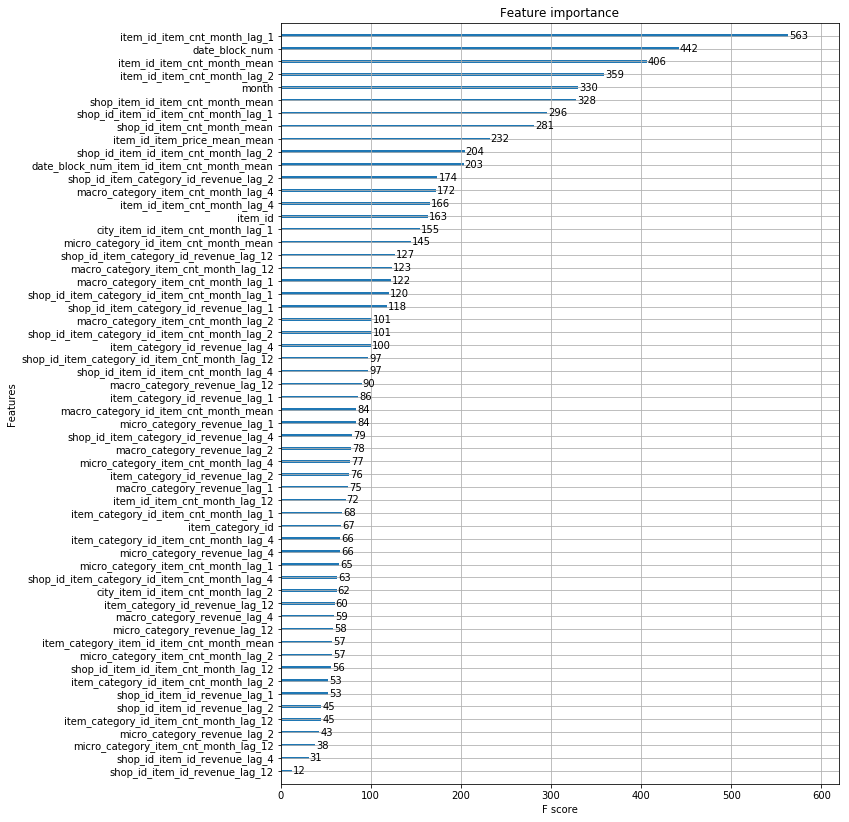

In [348]:
plot_feature_importances(gs.best_estimator_)

### Train using model with the best hyperparameters on the whole train set and make predictions for test set (block_num=34)

In [355]:
import joblib
monthly_sales = joblib.load('monthly_sales_XGboost.pkl')
#monthly_sales = monthly_sales.reset_index().drop("index", axis=1)

In [356]:
X_train = monthly_sales[monthly_sales['date_block_num']<34]
X_test = monthly_sales[monthly_sales['date_block_num']==34]

X_train, y_train = helper.get_X_y(X_train, "item_cnt_month")
X_test, y_test = helper.get_X_y(X_test, "item_cnt_month")

In [359]:
start = time.time()

model = XGBRegressor(
    max_depth=8,
    n_estimators=70,
    min_child_weight=200, 
    colsample_bytree=0.8, 
    subsample=0.8, 
    eta=0.3,    
    seed=142
)


model.fit(
    X_train, 
    y_train, 
    eval_metric="rmse", 
    eval_set=[(X_train, y_train)], 
    verbose=2
)

time.time() - start

[21:30:15] Tree method is automatically selected to be 'approx' for faster speed. To use old behavior (exact greedy algorithm on single machine), set tree_method to 'exact'.
[0]	validation_0-rmse:1.15458
[2]	validation_0-rmse:1.05851
[4]	validation_0-rmse:0.987869
[6]	validation_0-rmse:0.936163
[8]	validation_0-rmse:0.897938
[10]	validation_0-rmse:0.869566
[12]	validation_0-rmse:0.84895
[14]	validation_0-rmse:0.832769
[16]	validation_0-rmse:0.820279
[18]	validation_0-rmse:0.810011
[20]	validation_0-rmse:0.803083
[22]	validation_0-rmse:0.797223
[24]	validation_0-rmse:0.792856
[26]	validation_0-rmse:0.788143
[28]	validation_0-rmse:0.784818
[30]	validation_0-rmse:0.782096
[32]	validation_0-rmse:0.779702
[34]	validation_0-rmse:0.777028
[36]	validation_0-rmse:0.774912
[38]	validation_0-rmse:0.772837
[40]	validation_0-rmse:0.77064
[42]	validation_0-rmse:0.769001
[44]	validation_0-rmse:0.767435
[46]	validation_0-rmse:0.765477
[48]	validation_0-rmse:0.763984
[50]	validation_0-rmse:0.762078
[52

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.8, eta=0.3, gamma=0, learning_rate=0.1,
       max_delta_step=0, max_depth=8, min_child_weight=200, missing=None,
       n_estimators=70, n_jobs=1, nthread=None, objective='reg:linear',
       random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=142, silent=True, subsample=0.8)

5546.035905122757

In [361]:
y_34_test = model.predict(X_test).clip(0,20)

from sklearn.externals import joblib
joblib.dump(model, "xgboost_allpoints_trained.joblib.dat")

helper.create_submission_csv("submission_xgboost_allpoints_trained.csv", test, y_34_test)

['xgboost_allpoints_trained.joblib.dat']

This submission resulted in 0.9645 score

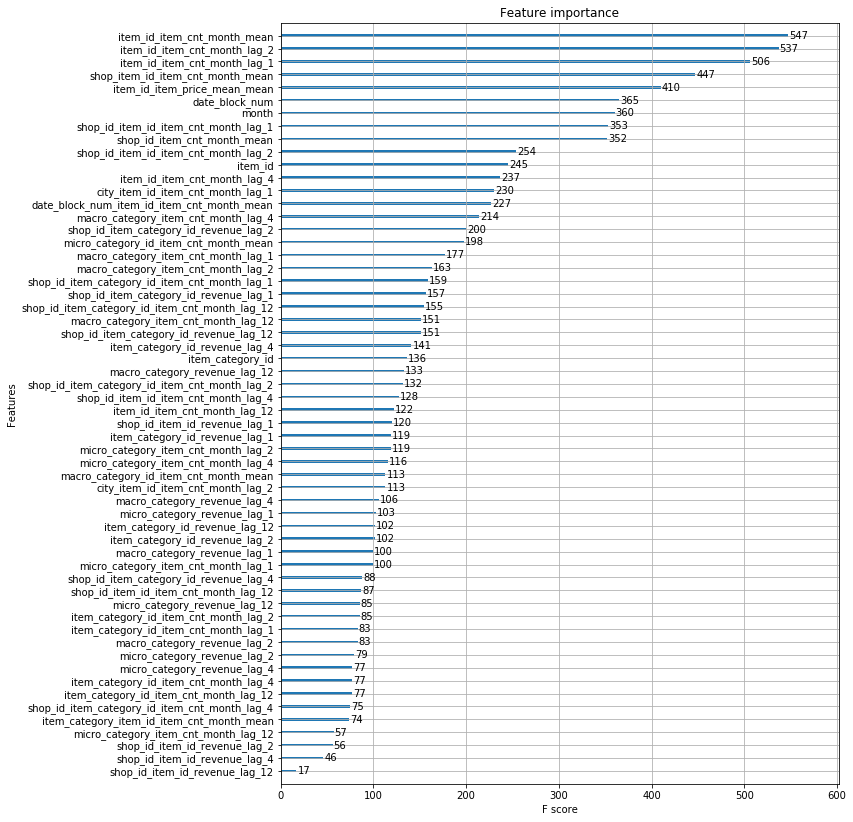

In [362]:
plot_feature_importances(model)

### <a class="anchor" id="Selection">Part IV : SGD model for NLP features</a>

In this part I will create DataSet using only categorical features:
1. Create tokenize function that will work with mizture of russian and english text. It will split text into words, remove punctuation, russian and english stopwords, stem russian words and lemmatize english words.
2. Apply TFIDF vectorizer for all item names from items dataset. Such operation will transform each name into vector of features that represent this name
3. Merge vector by item_id to final DataFrame.
4. Create dummy features on "shop_name", "item_category_name", "macro_category", "micro_category" and "city" columns

Finally, build SGD regressor and train model:
1. Split DataFrame to test, vidation and train set
2. Apply Standard Scaler to date_block_num
3. Train SGD model
4. Evaluate Performance

In [366]:
import joblib
monthly_sales = joblib.load('monthly_sales_clip20_after_means.pkl')

In [367]:
nlp_sales = monthly_sales[["date_block_num", "item_name", "shop_name", "item_category_name", "item_cnt_month"]]


#### Create tokenize function

In [368]:
def tokenize(text):
    """Tokenizes given text
    
    Parameters
    ----------
    text : str
        Text for tokenization
    
    Returns
    -------
    tokens : array of str
        Array of words
    
    """
    
    # normalize case and remove punctuation
    #english
    #text = re.sub(r"[^a-zA-Z0-9]", " ", text.lower())
    #russian
    text = re.sub(r"[^а-яА-яa-zA-Z0-9]", " ", text.lower())
    
    # tokenize text
    tokens = word_tokenize(text)
    
    # stop words
    stop_words = stopwords.words("russian") + stopwords.words("english")
    
    #Lemmatizing
    #lemmatizer = WordNetLemmatizer()
    #tokens = [lemmatizer.stem(word).strip() for word in tokens if word not in stop_words]
    
    #stemming of russian 
    stemmer = SnowballStemmer("russian")
    tokens = [stemmer.stem(word).strip() for word in tokens if word not in stop_words]
    
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.stem(word).strip() for word in tokens]
    
    return tokens

#### Create DataFrame of item_id and item_name presented by item_name vectors

For TfidfVectorizer I use 2-grams. I could also add single words but it will dramaticaly increase number of features.

In [153]:
t0 = time.time()
X = items[["item_id","item_name"]]
tfidfv = TfidfVectorizer(tokenizer=tokenize,ngram_range=(2, 2), min_df=0.001, max_df=0.5)
res = tfidfv.fit_transform(X["item_name"])
res_df = pd.DataFrame(res.toarray(), columns=tfidfv.get_feature_names()).astype('int8')
print(time.time()-t0)
res_df.columns


17.22790765762329


Index(['000 dawn', '1 2', '1 4', '1 mp3', '1 year', '1 год', '1 пк',
       '1 регион', '10 минут', '1с аудиокниг',
       ...
       'част 1', 'част 2', 'человек паук', 'черепашк ниндз', 'черн l',
       'черн флаг', 'шерлок холмс', 'школ волшебниц', 'э bd', 'экз 1с'],
      dtype='object', length=348)

In [154]:
res_df = pd.concat([X["item_id"], res_df], axis=1)
res_df.columns

Index(['item_id', '000 dawn', '1 2', '1 4', '1 mp3', '1 year', '1 год', '1 пк',
       '1 регион', '10 минут',
       ...
       'част 1', 'част 2', 'человек паук', 'черепашк ниндз', 'черн l',
       'черн флаг', 'шерлок холмс', 'школ волшебниц', 'э bd', 'экз 1с'],
      dtype='object', length=349)

#### Merge nlp_sales with item_name_vectors 

In [155]:
t0 = time.time()
nlp_sales = pd.merge(monthly_sales[["date_block_num", "shop_id", "item_id", 
                                    "city", "macro_category", "micro_category", "item_cnt_month"]], res_df, how='left')
print(time.time()-t0)

4.4320268630981445


In [156]:
nlp_sales.head()

,date_block_num,shop_id,item_id,city,macro_category,micro_category,item_cnt_month,000 dawn,1 2,1 4,...,част 1,част 2,человек паук,черепашк ниндз,черн l,черн флаг,шерлок холмс,школ волшебниц,э bd,экз 1с
0,12,2,32,1,10,3,1.0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,12,2,33,1,10,14,1.0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,12,2,99,1,10,14,1.0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,12,2,482,1,14,0,2.0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,12,2,485,1,14,0,1.0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


#### Create dummy columns

In [157]:
t0 = time.time()
nlp_sales.drop(["item_id"], axis=1, inplace=True)
nlp_sales = pd.get_dummies(nlp_sales, columns=["shop_id","macro_category", "micro_category", "city"], drop_first=True)
print(time.time()-t0)
nlp_sales.shape

13.87624192237854


(6409406, 508)

In [158]:
nlp_sales.head()

,date_block_num,item_cnt_month,000 dawn,1 2,1 4,1 mp3,1 year,1 год,1 пк,1 регион,...,city_19,city_20,city_21,city_22,city_23,city_24,city_25,city_26,city_27,city_28
0,12,1.0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,12,1.0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,12,1.0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,12,2.0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,12,1.0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [159]:
t0 = time.time()
import joblib

#write monthly_sales to pickle
joblib.dump(nlp_sales, "monthly_sales_SGD.pkl")
print(time.time()-t0)

['nlp_sales_clip30.pkl']

5.318334102630615


### Build SGD Model

In [6]:
#nlp_sales = pd.read_pickle('nlp_sales.pkl')
nlp_sales = joblib.load('monthly_sales_SGD.pkl')

In [ ]:
scaler = StandardScaler().fit(nlp_sales["date_block_num"].values.reshape(-1, 1))
nlp_sales["date_block_num2"] = scaler.transform(nlp_sales["date_block_num"].values.reshape(-1, 1))

In [7]:
#split to train, validation and test set
X_train = nlp_sales[nlp_sales['date_block_num']<34].drop("date_block_num", axis=1)
X_val = nlp_sales[nlp_sales['date_block_num']==33].drop("date_block_num", axis=1)
X_test = nlp_sales[nlp_sales['date_block_num']==34].drop("date_block_num", axis=1)

In [8]:
del nlp_sales
gc.collect()

81

In [9]:
X_train, y_train = helper.get_X_y(X_train, "item_cnt_month")
X_val, y_val = helper.get_X_y(X_val, "item_cnt_month")
X_test, y_test = helper.get_X_y(X_test, "item_cnt_month")

In [75]:
X_train.head()

,date_block_num,000 dawn,1 2,1 4,1 mp3,1 year,1 год,1 пк,1 регион,10 минут,...,city_19,city_20,city_21,city_22,city_23,city_24,city_25,city_26,city_27,city_28
0,12,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,12,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,12,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,12,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,12,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


#### Tuning of hyperparameters with GridSearchCV

In [103]:
t0 = time.time()
sgd = SGDRegressor(max_iter=100, verbose=2, tol=1e-3)

parameters = {
    "penalty" : ["l1", "l2"]
}

# use grid search to find better parameters. 

gs = GridSearchCV(sgd, param_grid=parameters, verbose=4, cv=cv)

gs.fit(X_train, y_train)
print(time.time()-t0)

-- Epoch 1
Norm: 6.10, NNZs: 325, Bias: 0.590549, T: 5973404, Avg. loss: 0.645663
Total training time: 43.37 seconds.
-- Epoch 2
Norm: 7.98, NNZs: 325, Bias: 0.625622, T: 11946808, Avg. loss: 0.634978
Total training time: 88.37 seconds.
-- Epoch 3
Norm: 9.14, NNZs: 325, Bias: 0.615599, T: 17920212, Avg. loss: 0.631178
Total training time: 136.22 seconds.
-- Epoch 4
Norm: 9.90, NNZs: 325, Bias: 0.624488, T: 23893616, Avg. loss: 0.629026
Total training time: 180.80 seconds.
-- Epoch 5
Norm: 10.47, NNZs: 325, Bias: 0.641927, T: 29867020, Avg. loss: 0.627718
Total training time: 230.88 seconds.
-- Epoch 6
Norm: 10.89, NNZs: 325, Bias: 0.651666, T: 35840424, Avg. loss: 0.626795
Total training time: 278.92 seconds.
-- Epoch 7
Norm: 11.20, NNZs: 325, Bias: 0.648335, T: 41813828, Avg. loss: 0.626154
Total training time: 323.53 seconds.
-- Epoch 8
Norm: 11.44, NNZs: 325, Bias: 0.646499, T: 47787232, Avg. loss: 0.625719
Total training time: 371.40 seconds.
-- Epoch 9
Norm: 11.64, NNZs: 325, Bias

SGDRegressor(alpha=0.0001, average=False, early_stopping=False, epsilon=0.1,
       eta0=0.01, fit_intercept=True, l1_ratio=0.15,
       learning_rate='invscaling', loss='squared_loss', max_iter=1000,
       n_iter=None, n_iter_no_change=5, penalty='l2', power_t=0.25,
       random_state=None, shuffle=True, tol=0.001, validation_fraction=0.1,
       verbose=2, warm_start=False)

630.5776088237762


In [ ]:
y_pred = sgd.predict(X_train)

In [104]:
mean_squared_error(y_train, y_pred)

1.2498461336356683

In [106]:
y_pred = sgd.predict(X_val)
mean_squared_error(y_val, y_pred)

1.027532587549051

In [109]:
# X_train = nlp_sales[nlp_sales['date_block_num']<34]
# X_train, y_train = helper.get_X_y(X_train, "date_block_num")
# y_train.fillna(0,inplace=True)

/anaconda3/lib/python3.7/site-packages/pandas/core/generic.py:5434: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)


In [111]:
y_pred = sgd.predict(X_test)
#mean_squared_error(y_val, y_pred)

(array([1.76467e+05, 3.62360e+04, 1.11800e+03, 1.24000e+02, 1.51000e+02,
        2.00000e+01, 3.70000e+01, 5.00000e+00, 0.00000e+00, 4.20000e+01]),
 array([-0.57031488,  0.56113657,  1.69258801,  2.82403946,  3.95549091,
         5.08694235,  6.2183938 ,  7.34984524,  8.48129669,  9.61274813,
        10.74419958]),
 <a list of 10 Patch objects>)

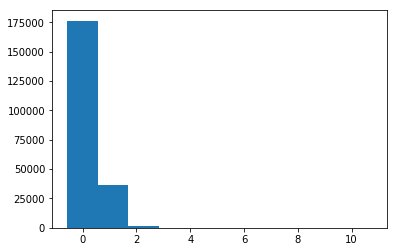

In [114]:
plt.hist(y_pred)

In [115]:
y_pred = y_pred.clip(0,20)

In [117]:
helper.create_submission_csv("submission_sgd_shuffle_32.csv", test, y_pred)

Your submission scored 1.14069, which is not an improvement of your best score. Keep trying!

In [17]:
#use without validation
#nlp_sales = joblib.load('nlp_sales.pkl')
#X_train = nlp_sales[nlp_sales['date_block_num']<34]
#X_train["date_block_num"] = scaler.transform(X_train["date_block_num"].values.reshape(-1, 1))
#X_train, y_train = helper.get_X_y(X_train, "item_cnt_month")
y_train.fillna(0,inplace=True)

#del nlp_sales
#gc.collect()

t0 = time.time()
sgd = SGDRegressor(max_iter=100, verbose=2, tol=1e-3, shuffle=False)
sgd.fit(X_train, y_train)
y_pred = sgd.predict(X_train)
y_pred = y_pred.clip(0,20)
print(mean_squared_error(y_train, y_pred))
print(time.time()-t0)

-- Epoch 1
Norm: 7.39, NNZs: 328, Bias: 0.747926, T: 6195206, Avg. loss: 0.773385
Total training time: 28.66 seconds.
-- Epoch 2
Norm: 10.15, NNZs: 328, Bias: 0.484610, T: 12390412, Avg. loss: 0.764851
Total training time: 57.24 seconds.
-- Epoch 3
Norm: 11.87, NNZs: 328, Bias: 0.632066, T: 18585618, Avg. loss: 0.760215
Total training time: 85.07 seconds.
-- Epoch 4
Norm: 13.03, NNZs: 328, Bias: 0.605702, T: 24780824, Avg. loss: 0.757606
Total training time: 112.83 seconds.
-- Epoch 5
Norm: 13.87, NNZs: 328, Bias: 0.633110, T: 30976030, Avg. loss: 0.756088
Total training time: 142.30 seconds.
-- Epoch 6
Norm: 14.49, NNZs: 328, Bias: 0.634358, T: 37171236, Avg. loss: 0.755140
Total training time: 171.48 seconds.
-- Epoch 7
Norm: 14.96, NNZs: 328, Bias: 0.644239, T: 43366442, Avg. loss: 0.754551
Total training time: 199.85 seconds.
-- Epoch 8
Norm: 15.32, NNZs: 328, Bias: 0.647966, T: 49561648, Avg. loss: 0.754181
Total training time: 229.23 seconds.
-- Epoch 9
Norm: 15.60, NNZs: 328, Bi

SGDRegressor(alpha=0.0001, average=False, early_stopping=False, epsilon=0.1,
       eta0=0.01, fit_intercept=True, l1_ratio=0.15,
       learning_rate='invscaling', loss='squared_loss', max_iter=100,
       n_iter=None, n_iter_no_change=5, penalty='l2', power_t=0.25,
       random_state=None, shuffle=False, tol=0.001,
       validation_fraction=0.1, verbose=2, warm_start=False)

1.5850579570768046
467.11792397499084


In [13]:
y_pred = sgd.predict(X_test)
#mean_squared_error(y_val, y_pred)

(array([2.11747e+05, 2.19500e+03, 6.00000e+00, 1.68000e+02, 0.00000e+00,
        4.00000e+01, 2.00000e+00, 0.00000e+00, 0.00000e+00, 4.20000e+01]),
 array([-0.64626262,  0.96804209,  2.58234679,  4.1966515 ,  5.81095621,
         7.42526092,  9.03956563, 10.65387034, 12.26817505, 13.88247976,
        15.49678447]),
 <a list of 10 Patch objects>)

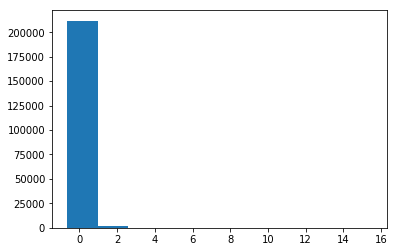

In [14]:
plt.hist(y_pred)

In [15]:
y_pred = y_pred.clip(0,20)

In [128]:
helper.create_submission_csv("submission_sgd_shuffle_33.csv", test, y_pred)

Your submission scored 1.13911, which is not an improvement of your best score. Keep trying!


In [16]:
helper.create_submission_csv("submission_sgd_shuffle_33_noshuffle_e4.csv", test, y_pred)

Your submission scored 1.14625, which is not an improvement of your best score. Keep trying!

### <a class="anchor" id="Ensembling">Part V : Ensembling</a>

### First level models 

I will implement a basic stacking scheme for time series model. 
First, I use results from two previous models (SGD and XGBoost) to  build test set metafeatures. Then  I use k-fold scheme to create 2-nd level train-metafetures.


#### Test meta-features

In [19]:
pred_sgd = pd.read_csv("submission_sgd_allpoints_trained.csv")["item_cnt_month"]
pred_xgboost = pd.read_csv("submission_xgboost_allpoints_trained.csv")["item_cnt_month"]

In [26]:
X_test_level2 = np.c_[pred_sgd, pred_xgboost] 

In [27]:
X_test_level2

array([[0.49038335, 0.6652341 ],
       [0.12720851, 0.19358689],
       [0.49038335, 1.0790966 ],
       ...,
       [0.02800053, 0.0804598 ],
       [0.08100361, 0.02310044],
       [0.01002214, 0.08566803]])

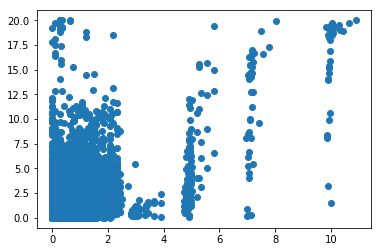

In [30]:
plt.scatter(X_test_level2[:,0],X_test_level2[:,1], )

There is very strange dependents between two models. The linear model is not suitable here for stacking perposes. I would try some tree based model that can split this dependents into different ranges.

### Train meta-features

Validation in presence of time component


#### KFold scheme in time series

In time-series task we usually have a fixed period of time we are asked to predict. Like day, week, month or arbitrary period with duration of T.

Split the train data into chunks of duration T. Select first M chunks.   
Fit N diverse models on those M chunks and predict for the chunk M+1. Then fit those models on first M+1 chunks and predict for chunk M+2 and so on, until you hit the end. After that use all train data to fit models and get predictions for test. Now we will have meta-features for the chunks starting from number M+1 as well as meta-features for the test.   
Now we can use meta-features from first K chunks [M+1,M+2,..,M+K] to fit level 2 models and validate them on chunk M+K+1. Essentially we are back to step 1. with the lesser amount of chunks and meta-features instead of features.  

M=15, T= month 

Need to get predictions (meta-features) from *sgd* and *xgboost* for months 27, 28, 29, 30, 31, 32,  using the same parameters as in above models.

In [ ]:
# Load train and test set for XGboost model
import joblib
monthly_sales = joblib.load('monthly_sales_XGboost.pkl')
monthly_sales = monthly_sales.reset_index().drop("index", axis=1)

X_train = monthly_sales[monthly_sales['date_block_num']<34]
X_test = monthly_sales[monthly_sales['date_block_num']==34]

X_train, y_train = helper.get_X_y(X_train, "item_cnt_month")
X_test, y_test = helper.get_X_y(X_test, "item_cnt_month")

model = XGBRegressor(
    max_depth=8,
    n_estimators=50,
    min_child_weight=200, 
    colsample_bytree=0.8, 
    subsample=0.8, 
    eta=0.3,    
    seed=142
)

# model.fit(
#     X_train, 
#     y_train, 
#     eval_metric="rmse", 
#     eval_set=[(X_train, y_train)], 
#     verbose=2
# )


In [ ]:
#Load train and test set for SGD model
nlp_sales = joblib.load('monthly_sales_SGD.pkl')
monthly_sales = monthly_sales.reset_index().drop("index", axis=1)

scaler = StandardScaler().fit(nlp_sales["date_block_num"].values.reshape(-1, 1))
nlp_sales["date_block_num2"] = scaler.transform(nlp_sales["date_block_num"].values.reshape(-1, 1))

#save block_dates
dates

#split to train, validation and test set
X_train = nlp_sales[nlp_sales['date_block_num']<34]
X_test = nlp_sales[nlp_sales['date_block_num']==34] #.drop("date_block_num", axis=1)

del nlp_sales
gc.collect()

X_train, y_train = helper.get_X_y(X_train, "item_cnt_month")
X_test, y_test = helper.get_X_y(X_test, "item_cnt_month")

In [ ]:
dates_train_level2 = dates_train[dates_train.isin([28, 29, 30, 31, 32])]

#target for the 2nd level dataset
y_train_level2 = y_train[dates_train.isin([28, 29, 30, 31, 32])]

In [ ]:
#create 2nd level feeature matrix, init it with zeros first
X_train_level2 = np.zeros([y_train_level2.shape[0], 2])
#print(X_train_level2.shape)
#X_train_level2 = [[]]
# Now fill `X_train_level2` with metafeatures
for cur_block_num in [27, 28, 29, 30, 31, 32]:
    
    print(cur_block_num)
    
    dates_train2 = dates[dates <  cur_block_num]
    dates_test2  = dates[dates == cur_block_num]

    X_train2 = all_data.loc[dates <  cur_block_num].drop(to_drop_cols, axis=1)
    X_test2 =  all_data.loc[dates == cur_block_num].drop(to_drop_cols, axis=1)

    y_train2 = all_data.loc[dates <  cur_block_num, 'target'].values
    y_test2 =  all_data.loc[dates == cur_block_num, 'target'].values
    
    lr = LinearRegression()
    lr.fit(X_train2.values, y_train2)
    pred_2lr = lr.predict(X_test2.values)
    
    model = lgb.train(lgb_params, lgb.Dataset(X_train2, label=y_train2), 100)
    pred_2lgb = model.predict(X_test2)

    #print((X_train_level2==0).sum())
    X_train_level2[dates_train_level2.values==cur_block_num] = np.c_[pred_2lr,pred_2lgb]
    #print((X_train_level2==0).sum())
    
    '''
        1. Split `X_train` into parts
           Remember, that corresponding dates are stored in `dates_train` 
        2. Fit linear regression 
        3. Fit LightGBM and put predictions           
        4. Store predictions from 2. and 3. in the right place of `X_train_level2`. 
           You can use `dates_train_level2` for it
           Make sure the order of the meta-features is the same as in `X_test_level2`
    '''      
    
    #  YOUR CODE GOES HERE
    
print(X_train_level2.mean(axis=0))    
# Sanity check

### Stacking

Now, we will try a more advanced ensembling technique. Fit a linear regression model to the meta-features. Use the same parameters as in the model above.